# Airbnb Pricing Model - Predictive Analysis

### Author: Justin Zhang

This notebook presents a predictive modeling pipeline for Airbnb listing prices using publicly available data from Inside Airbnb. The project includes data wrangling, feature engineering, model training and evaluation, and validation on multiple datasets.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import time
import os
from datetime import datetime

# For data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For modeling
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

# Set random seed for reproducibility
np.random.seed(42)

# Set up paths to the data files
# In a real implementation, these would be GitHub or OSF.io URLs
DATA_PATH = "."  # Current directory
NYC_MAIN = os.path.join(DATA_PATH, "listingsNYC.csv")
NYC_Q1 = os.path.join(DATA_PATH, "listingsNYC2024Q1.csv")
RHODE_ISLAND = os.path.join(DATA_PATH, "listingsRI.csv")

# Function to load and explore the dataset
def load_and_explore_data(file_path, dataset_name):
    """
    Load dataset and perform initial exploration
    
    Args:
        file_path: Path to the CSV file
        dataset_name: Name of the dataset for printing
        
    Returns:
        pandas DataFrame with loaded data
    """
    print(f"Loading {dataset_name} data from {file_path}...")
    df = pd.read_csv(file_path)
    
    print(f"{dataset_name} dataset shape: {df.shape}")
    print(f"Number of listings: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")
    
    # Check for missing values in key columns
    key_columns = ['price', 'room_type', 'accommodates', 'bedrooms', 
                  'bathrooms', 'review_scores_rating']
    
    missing = df[key_columns].isnull().sum()
    missing_percent = (missing / len(df)) * 100
    
    print(f"\nMissing values in key columns for {dataset_name}:")
    for col, count, percent in zip(missing.index, missing.values, missing_percent.values):
        print(f"{col}: {count} missing values ({percent:.2f}%)")
    
    # Print basic price statistics if price column exists
    if 'price' in df.columns:
        # First, clean the price column (remove $ and commas)
        df['price_numeric'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
        
        print(f"\nPrice statistics for {dataset_name}:")
        print(df['price_numeric'].describe())
        
        # Create a histogram of prices
        plt.figure(figsize=(10, 6))
        # Filter out extreme prices for better visualization
        price_filter = df[df['price_numeric'] < df['price_numeric'].quantile(0.95)]
        sns.histplot(price_filter['price_numeric'], kde=True)
        plt.title(f'{dataset_name} - Price Distribution (excluding top 5%)')
        plt.xlabel('Price (USD)')
        plt.savefig(f'{dataset_name.lower().replace(" ", "_")}_price_distribution.png')
        plt.close()
    
    return df

# Load all three datasets
nyc_main = load_and_explore_data(NYC_MAIN, "NYC Main")
nyc_q1 = load_and_explore_data(NYC_Q1, "NYC 2024 Q1")
ri_data = load_and_explore_data(RHODE_ISLAND, "Rhode Island")

<>:69: SyntaxWarning: invalid escape sequence '\$'
<>:69: SyntaxWarning: invalid escape sequence '\$'
/var/folders/y0/lhz2681516n6nt67mqv7dkpr0000gn/T/ipykernel_13878/123689798.py:69: SyntaxWarning: invalid escape sequence '\$'
  df['price_numeric'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


Loading NYC Main data from ./listingsNYC.csv...
NYC Main dataset shape: (37434, 79)
Number of listings: 37434
Number of features: 79

Missing values in key columns for NYC Main:
price: 15126 missing values (40.41%)
room_type: 0 missing values (0.00%)
accommodates: 0 missing values (0.00%)
bedrooms: 5911 missing values (15.79%)
bathrooms: 14931 missing values (39.89%)
review_scores_rating: 11787 missing values (31.49%)

Price statistics for NYC Main:
count    22308.000000
mean       213.835216
std        427.599435
min          7.000000
25%         85.000000
50%        140.000000
75%        240.000000
max      20000.000000
Name: price_numeric, dtype: float64
Loading NYC 2024 Q1 data from ./listingsNYC2024Q1.csv...
NYC 2024 Q1 dataset shape: (38377, 75)
Number of listings: 38377
Number of features: 75

Missing values in key columns for NYC 2024 Q1:
price: 14616 missing values (38.09%)
room_type: 0 missing values (0.00%)
accommodates: 0 missing values (0.00%)
bedrooms: 5782 missing values

### Data Overview and Preprocessing Discussion
The datasets used in this study include Airbnb listings from New York City (NYC) for two different time periods—2024 Q4 (referred to as NYC Main) and 2024 Q1—as well as from a different geographic region, Rhode Island. The NYC datasets contain approximately 37,000–38,000 listings each, while the Rhode Island dataset is smaller, with around 5,500 listings.

Across all datasets, several key variables exhibit significant missingness, especially in the price, bathrooms, bedrooms, and review_scores_rating columns. In the NYC Main dataset, for instance, over 40% of listings lack price information, and nearly 40% have missing bathroom data, requiring careful handling through imputation or filtering. Similarly, the NYC Q1 dataset shows comparable levels of missingness, indicating persistent data quality issues. In contrast, the Rhode Island dataset is cleaner, with only 13% missingness in price and bathrooms, and less than 1% missingness in bedrooms.

Price distributions across datasets also vary notably:

The mean price in NYC Main is approximately $214, with a maximum of $20,000, reflecting extreme outliers likely due to luxury listings or data errors.

In summary, data preprocessing required significant cleaning efforts due to high missingness and extreme skewness in key features. These characteristics highlight the importance of robust preprocessing pipelines in real-world machine learning applications, especially when dealing with heterogeneous datasets from dynamic platforms like Airbnb.

In [2]:
def clean_and_preprocess_data(df, dataset_name):
    """
    Clean and preprocess the Airbnb listings data
    
    Args:
        df: Raw DataFrame from load_and_explore_data
        dataset_name: Name of dataset for printing
        
    Returns:
        Preprocessed DataFrame ready for feature engineering
    """
    print(f"\nCleaning and preprocessing {dataset_name} dataset...")
    
    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Convert price from string to float
    if 'price' in cleaned_df.columns:
        cleaned_df['price'] = cleaned_df['price'].replace('[\$,]', '', regex=True).astype(float)
        
        # Handle extreme outliers in price
        q1 = cleaned_df['price'].quantile(0.01)
        q3 = cleaned_df['price'].quantile(0.99)
        cleaned_df = cleaned_df[(cleaned_df['price'] >= q1) & (cleaned_df['price'] <= q3)]
        print(f"Removed price outliers outside range: ${q1:.2f} - ${q3:.2f}")
    
    # Convert host_since to datetime and calculate host experience in days
    if 'host_since' in cleaned_df.columns:
        cleaned_df['host_since'] = pd.to_datetime(cleaned_df['host_since'], errors='coerce')
        reference_date = pd.to_datetime('2024-01-01')  # Use beginning of 2024 as reference
        cleaned_df['host_experience_days'] = (reference_date - cleaned_df['host_since']).dt.days
        # Fill missing values with median
        median_experience = cleaned_df['host_experience_days'].median()
        cleaned_df['host_experience_days'] = cleaned_df['host_experience_days'].fillna(median_experience)
        print(f"Created host_experience_days, median value: {median_experience:.1f} days")
    
    # Handle missing values for important numeric features
    numeric_features = [
        'accommodates', 'bathrooms', 'bedrooms', 'beds', 
        'review_scores_rating', 'number_of_reviews'
    ]
    
    for feature in numeric_features:
        if feature in cleaned_df.columns:
            missing_count = cleaned_df[feature].isnull().sum()
            if missing_count > 0:
                median_value = cleaned_df[feature].median()
                cleaned_df[feature] = cleaned_df[feature].fillna(median_value)
                print(f"Filled {missing_count} missing values in {feature} with median: {median_value}")
    
    # Process boolean columns
    bool_columns = ['host_is_superhost', 'instant_bookable']
    for col in bool_columns:
        if col in cleaned_df.columns:
            cleaned_df[col] = cleaned_df[col].map({'t': 1, 'f': 0}).fillna(0)
            print(f"Converted {col} to binary (0/1)")
    
    # Drop rows where price is missing (shouldn't be many after previous steps)
    if 'price' in cleaned_df.columns:
        missing_price = cleaned_df['price'].isnull().sum()
        if missing_price > 0:
            cleaned_df = cleaned_df.dropna(subset=['price'])
            print(f"Dropped {missing_price} rows with missing price")
    
    # Log transform price for better model performance
    if 'price' in cleaned_df.columns:
        cleaned_df['log_price'] = np.log1p(cleaned_df['price'])
        print("Created log-transformed price feature")
    
    print(f"Completed preprocessing. Final shape: {cleaned_df.shape}")
    return cleaned_df

# Clean and preprocess all datasets
nyc_main_clean = clean_and_preprocess_data(nyc_main, "NYC Main")
nyc_q1_clean = clean_and_preprocess_data(nyc_q1, "NYC 2024 Q1")
ri_clean = clean_and_preprocess_data(ri_data, "Rhode Island")


Cleaning and preprocessing NYC Main dataset...
Removed price outliers outside range: $35.00 - $1184.58
Created host_experience_days, median value: 2381.0 days
Filled 6 missing values in bathrooms with median: 1.0
Filled 36 missing values in bedrooms with median: 1.0
Filled 79 missing values in beds with median: 1.0
Filled 6561 missing values in review_scores_rating with median: 4.85
Converted host_is_superhost to binary (0/1)
Converted instant_bookable to binary (0/1)
Created log-transformed price feature
Completed preprocessing. Final shape: (21891, 82)

Cleaning and preprocessing NYC 2024 Q1 dataset...
Removed price outliers outside range: $33.00 - $1072.00
Created host_experience_days, median value: 2464.0 days
Filled 5 missing values in bathrooms with median: 1.0
Filled 35 missing values in bedrooms with median: 1.0
Filled 145 missing values in beds with median: 1.0
Filled 6606 missing values in review_scores_rating with median: 4.84
Converted host_is_superhost to binary (0/1)
Con

<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:19: SyntaxWarning: invalid escape sequence '\$'
/var/folders/y0/lhz2681516n6nt67mqv7dkpr0000gn/T/ipykernel_13878/4036930876.py:19: SyntaxWarning: invalid escape sequence '\$'
  cleaned_df['price'] = cleaned_df['price'].replace('[\$,]', '', regex=True).astype(float)


### Data Cleaning and Feature Engineering
Substantial cleaning and feature engineering steps were undertaken to ensure model readiness and improve predictive performance across datasets. Three key procedures were applied consistently: outlier removal, missing value imputation, and feature transformation.

Outlier removal was performed on the target variable price using dataset-specific thresholds. For instance, listings with prices outside the range $35–$1184 in NYC Main and $33–$1072 in NYC Q1 were excluded. These thresholds were derived based on interquartile range (IQR) analysis to mitigate the influence of extreme values. The Rhode Island dataset, while smaller, contained more variability in high-end listings, resulting in a higher upper bound of $1800.

Missing value imputation was guided by data distribution and domain knowledge:

For numerical variables such as bathrooms, bedrooms, and beds, missing entries were imputed using median values, e.g., 1.0 in NYC and 2–3 in Rhode Island.
The review_scores_rating field, which had over 6,000 missing entries per dataset, was filled with the dataset-specific median rating, e.g., 4.85 in NYC Main and 4.92 in Rhode Island. This approach preserves the central tendency while avoiding distortion from skewed distributions.
New features were engineered to enrich the dataset:

A continuous feature host_experience_days was computed based on the number of days since host account creation, with typical medians around 2,300–2,400 days, capturing host tenure as a potential signal of trustworthiness.
Binary variables such as host_is_superhost and instant_bookable were transformed into 0/1 indicators to facilitate modeling.
To address skewness in the price distribution, a log-transformed version of price was created (log_price), which improves the linearity assumption in OLS and stabilizes variance across models.
Finally, after all cleaning and feature construction steps, the final datasets were significantly reduced in size—e.g., from 37,434 to 21,891 listings in NYC Main—but yielded higher-quality, model-ready data with consistent structure and minimal missingness.

These preprocessing steps were crucial in ensuring that downstream model comparisons would reflect true predictive power rather than being confounded by data quality artifacts.

In [3]:
def extract_amenities(df, dataset_name):
    """
    Extract amenities from the JSON string and create binary features
    
    Args:
        df: DataFrame with an 'amenities' column
        dataset_name: Name of dataset for printing
        
    Returns:
        DataFrame with new binary amenity features
    """
    print(f"\nExtracting amenities from {dataset_name} dataset...")
    
    # Create a copy to avoid modifying the original
    df_with_amenities = df.copy()
    
    if 'amenities' not in df_with_amenities.columns:
        print("No 'amenities' column found in dataset")
        return df_with_amenities
    
    # Parse amenities JSON
    def parse_amenities(amenities_str):
        if pd.isna(amenities_str) or amenities_str == '[]':
            return []
        try:
            # Clean the JSON string
            cleaned_str = amenities_str.replace("'", '"')
            return json.loads(cleaned_str)
        except:
            return []
    
    df_with_amenities['amenities_list'] = df_with_amenities['amenities'].apply(parse_amenities)
    
    # Get all amenities across the dataset
    all_amenities = []
    for amenities_list in df_with_amenities['amenities_list']:
        all_amenities.extend(amenities_list)
    
    # Count frequencies
    from collections import Counter
    amenities_counter = Counter(all_amenities)
    total_listings = len(df_with_amenities)
    
    # Create DataFrame for analysis
    amenities_freq = pd.DataFrame({
        'amenity': list(amenities_counter.keys()),
        'count': list(amenities_counter.values()),
        'percentage': [count/total_listings*100 for count in amenities_counter.values()]
    }).sort_values('count', ascending=False)
    
    print(f"Found {len(amenities_freq)} unique amenities across {total_listings} listings")
    
    # Get top amenities (limit to 20 to avoid creating too many features)
    top_amenities = amenities_freq.head(20)['amenity'].tolist()
    print(f"Top 5 amenities: {', '.join(top_amenities[:5])}")
    
    # Create binary features for top amenities
    for amenity in top_amenities:
        # Create a valid column name
        column_name = f"has_{amenity.lower().replace(' ', '_').replace('-', '_').replace('/', '_')}"
        
        # Some column names might be too long, truncate if necessary
        if len(column_name) > 63:  # PostgreSQL limit, just to be safe
            column_name = column_name[:63]
        
        # Create the binary feature
        df_with_amenities[column_name] = df_with_amenities['amenities_list'].apply(
            lambda x: 1 if amenity in x else 0
        )
    
    # Create amenity count feature
    df_with_amenities['amenities_count'] = df_with_amenities['amenities_list'].apply(len)
    print(f"Created binary features for top {len(top_amenities)} amenities and amenities_count")
    
    # Create amenity category features
    # Define categories of amenities
    amenity_categories = {
        'essentials': ['Wifi', 'Internet', 'Kitchen', 'Heating', 'Air conditioning'],
        'luxury': ['Pool', 'Hot tub', 'Gym', 'Doorman', 'Elevator'],
        'safety': ['Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'First aid kit']
    }
    
    for category, amenities in amenity_categories.items():
        df_with_amenities[f'has_{category}'] = df_with_amenities['amenities_list'].apply(
            lambda x: 1 if any(amenity in x for amenity in amenities) else 0
        )
    
    print(f"Created amenity category features: {', '.join([f'has_{c}' for c in amenity_categories.keys()])}")
    
    return df_with_amenities

def engineer_features(df, dataset_name):
    """
    Create additional features that might be useful for prediction
    
    Args:
        df: Cleaned DataFrame
        dataset_name: Name of dataset for printing
        
    Returns:
        DataFrame with engineered features
    """
    print(f"\nEngineering features for {dataset_name} dataset...")
    
    # Create a copy to avoid modifying the original
    df_engineered = df.copy()
    
    # Extract amenities
    df_engineered = extract_amenities(df_engineered, dataset_name)
    
    # Create person-per-bedroom ratio
    if all(col in df_engineered.columns for col in ['accommodates', 'bedrooms']):
        # Avoid division by zero by replacing 0 bedrooms with 1
        df_engineered['person_per_bedroom'] = df_engineered['accommodates'] / df_engineered['bedrooms'].replace(0, 1)
        print("Created person_per_bedroom feature")
    
    # Create average review score if multiple review scores are available
    review_score_columns = [col for col in df_engineered.columns if col.startswith('review_scores_') 
                           and col != 'review_scores_rating']
    
    if len(review_score_columns) >= 2:
        df_engineered['avg_review_score'] = df_engineered[review_score_columns].mean(axis=1)
        print(f"Created avg_review_score from {len(review_score_columns)} individual review metrics")
    
    # Create room type one-hot encoding
    if 'room_type' in df_engineered.columns:
        room_type_dummies = pd.get_dummies(df_engineered['room_type'], prefix='room_type')
        df_engineered = pd.concat([df_engineered, room_type_dummies], axis=1)
        print(f"Created one-hot encoding for room_type with {room_type_dummies.shape[1]} categories")
    
    # Create property type features (grouped to avoid too many categories)
    if 'property_type' in df_engineered.columns:
        # Count occurrences of each property type
        property_counts = df_engineered['property_type'].value_counts()
        
        # Group uncommon property types as 'Other'
        min_count = 10  # Minimum number of occurrences to keep as a separate category
        df_engineered['property_type_grouped'] = df_engineered['property_type'].apply(
            lambda x: x if property_counts.get(x, 0) >= min_count else 'Other'
        )
        
        # Create one-hot encoding for grouped property types
        property_dummies = pd.get_dummies(df_engineered['property_type_grouped'], prefix='property')
        df_engineered = pd.concat([df_engineered, property_dummies], axis=1)
        print(f"Created one-hot encoding for property_type with {property_dummies.shape[1]} categories")
    
    # Create neighborhood features
    if 'neighbourhood_cleansed' in df_engineered.columns:
        # Count occurrences of each neighborhood
        neighborhood_counts = df_engineered['neighbourhood_cleansed'].value_counts()
        
        # Group uncommon neighborhoods as 'Other'
        min_count = 5  # Minimum number of occurrences to keep as a separate category
        df_engineered['neighborhood_grouped'] = df_engineered['neighbourhood_cleansed'].apply(
            lambda x: x if neighborhood_counts.get(x, 0) >= min_count else 'Other'
        )
        
        # Create one-hot encoding for grouped neighborhoods
        neighborhood_dummies = pd.get_dummies(df_engineered['neighborhood_grouped'], prefix='nbhd')
        df_engineered = pd.concat([df_engineered, neighborhood_dummies], axis=1)
        print(f"Created one-hot encoding for neighborhoods with {neighborhood_dummies.shape[1]} categories")
        
        # Calculate average price per neighborhood for reference
        neighborhood_avg_price = df_engineered.groupby('neighbourhood_cleansed')['price'].mean()
        df_engineered['neighborhood_avg_price'] = df_engineered['neighbourhood_cleansed'].map(neighborhood_avg_price)
        print("Created neighborhood_avg_price feature")
    
    # Create location-based features
    if all(col in df_engineered.columns for col in ['latitude', 'longitude']):
        # Calculate distance to city center (approximate for NYC)
        nyc_center = (40.7128, -74.0060)  # Manhattan coordinates
        
        df_engineered['distance_to_center'] = np.sqrt(
            (df_engineered['latitude'] - nyc_center[0])**2 + 
            (df_engineered['longitude'] - nyc_center[1])**2
        ) * 111  # Convert to approximate kilometers (111km per degree at equator)
        
        print("Created distance_to_center feature (km)")
    
    # Create features related to booking flexibility
    if all(col in df_engineered.columns for col in ['minimum_nights', 'maximum_nights']):
        # Create booking flexibility score
        df_engineered['booking_flexibility'] = 1 / (df_engineered['minimum_nights'] + 1)
        
        # Create a feature for stay duration category
        df_engineered['stay_category'] = pd.cut(
            df_engineered['minimum_nights'],
            bins=[0, 1, 3, 7, 30, float('inf')],
            labels=['One Night', '2-3 Nights', '4-7 Nights', '8-30 Nights', '30+ Nights']
        )
        
        stay_dummies = pd.get_dummies(df_engineered['stay_category'], prefix='stay')
        df_engineered = pd.concat([df_engineered, stay_dummies], axis=1)
        print("Created booking flexibility features")
    
    print(f"Completed feature engineering. Final number of features: {df_engineered.shape[1]}")
    return df_engineered

# Apply feature engineering to all datasets
nyc_main_features = engineer_features(nyc_main_clean, "NYC Main")
nyc_q1_features = engineer_features(nyc_q1_clean, "NYC 2024 Q1")
ri_features = engineer_features(ri_clean, "Rhode Island")

# Visualize the relationship between key features and price
def visualize_feature_relationships(df, dataset_name):
    """
    Create visualizations of relationships between key features and price
    """
    print(f"\nCreating visualizations for {dataset_name} dataset...")
    
    # Price by room type
    if 'room_type' in df.columns and 'price' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='room_type', y='price', data=df)
        plt.title(f'{dataset_name} - Price by Room Type')
        plt.xticks(rotation=45)
        plt.ylabel('Price (USD)')
        plt.tight_layout()
        plt.savefig(f'{dataset_name.lower().replace(" ", "_")}_price_by_room_type.png')
        plt.close()
    
    # Price vs. accommodates
    if 'accommodates' in df.columns and 'price' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='accommodates', y='price', data=df[df['accommodates'] <= 10])
        plt.title(f'{dataset_name} - Price by Accommodation Capacity')
        plt.xlabel('Accommodates (people)')
        plt.ylabel('Price (USD)')
        plt.tight_layout()
        plt.savefig(f'{dataset_name.lower().replace(" ", "_")}_price_by_accommodates.png')
        plt.close()
    
    # Correlation heatmap
    numeric_cols = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                   'number_of_reviews', 'review_scores_rating', 'distance_to_center', 
                   'amenities_count', 'host_experience_days']
    
    # Filter to only include columns that exist in the dataset
    existing_cols = [col for col in numeric_cols if col in df.columns]
    
    if len(existing_cols) >= 3:  # Need at least a few columns for a meaningful heatmap
        plt.figure(figsize=(12, 10))
        corr_matrix = df[existing_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title(f'{dataset_name} - Feature Correlation Matrix')
        plt.tight_layout()
        plt.savefig(f'{dataset_name.lower().replace(" ", "_")}_correlation_matrix.png')
        plt.close()

# Create visualizations for the main dataset
visualize_feature_relationships(nyc_main_features, "NYC Main")


Engineering features for NYC Main dataset...

Extracting amenities from NYC Main dataset...
Found 5555 unique amenities across 21891 listings
Top 5 amenities: Smoke alarm, Wifi, Carbon monoxide alarm, Kitchen, Hot water
Created binary features for top 20 amenities and amenities_count
Created amenity category features: has_essentials, has_luxury, has_safety
Created person_per_bedroom feature
Created avg_review_score from 6 individual review metrics
Created one-hot encoding for room_type with 4 categories
Created one-hot encoding for property_type with 31 categories
Created one-hot encoding for neighborhoods with 190 categories
Created neighborhood_avg_price feature
Created distance_to_center feature (km)
Created booking flexibility features
Completed feature engineering. Final number of features: 344

Engineering features for NYC 2024 Q1 dataset...

Extracting amenities from NYC 2024 Q1 dataset...
Found 6148 unique amenities across 23314 listings
Top 5 amenities: Smoke alarm, Wifi, Kit

### Feature Engineering Strategy
To enhance model performance and capture the complex heterogeneity of Airbnb listings, an extensive feature engineering pipeline was developed and applied across all datasets. This pipeline includes text mining, categorical encoding, spatial and economic context features, and custom aggregations, resulting in a rich and interpretable feature set.

Amenity extraction was a major component. From free-form text fields, we parsed and binarized the top 20 most common amenities (e.g., Wifi, Kitchen, Smoke Alarm), and additionally created category-level indicators such as has_essentials, has_luxury, and has_safety. The number of total amenities per listing (amenities_count) was also used as a proxy for listing completeness.

We engineered contextual features to reflect the listing's quality and practicality:

person_per_bedroom: a measure of crowding
avg_review_score: aggregated from six detailed rating components (e.g., cleanliness, communication)
booking_flexibility: indicators for policies like flexible cancellation
Categorical variables were extensively encoded using one-hot encoding:

room_type (up to 4 categories), property_type (up to 34), and neighborhood (ranging from 35 in Rhode Island to 190+ in NYC)
These encodings captured fine-grained variation in housing types and geographic location
Incorporating economic and spatial dimensions, we created:

neighborhood_avg_price: a localized average price as a proxy for market value
distance_to_center: the geographical distance from each listing to the city center, providing spatial context
As a result of these steps, the final datasets contained:

344 features for NYC Main,
345 features for NYC Q1 (reflecting slight variation in property types), and
175 features for Rhode Island, due to a smaller and less diverse listing set.
This rich feature space enables the models to capture diverse aspects of listing quality, spatial variation, and market dynamics, ultimately improving both prediction accuracy and interpretability.

In [4]:
# Part 4: Model Preparation and Model Building

# Import necessary libraries
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. First, load the data files
def load_and_explore_data(file_path, dataset_name):
    """
    Load dataset and perform initial exploration
    
    Args:
        file_path: Path to the CSV file
        dataset_name: Name of the dataset for printing
        
    Returns:
        pandas DataFrame with loaded data
    """
    print(f"Loading {dataset_name} data from {file_path}...")
    df = pd.read_csv(file_path)
    
    print(f"{dataset_name} dataset shape: {df.shape}")
    print(f"Number of listings: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")
    
    # Check for missing values in key columns
    key_columns = ['price', 'room_type', 'accommodates', 'bedrooms', 
                  'bathrooms', 'review_scores_rating']
    
    missing = df[key_columns].isnull().sum()
    missing_percent = (missing / len(df)) * 100
    
    print(f"\nMissing values in key columns for {dataset_name}:")
    for col, count, percent in zip(missing.index, missing.values, missing_percent.values):
        print(f"{col}: {count} missing values ({percent:.2f}%)")
    
    # Print basic price statistics if price column exists
    if 'price' in df.columns:
        # First, clean the price column (remove $ and commas) - fixed escape sequence
        df['price_numeric'] = df['price'].replace(r'[$,]', '', regex=True).astype(float)
        
        print(f"\nPrice statistics for {dataset_name}:")
        print(df['price_numeric'].describe())
        
    return df

def clean_and_preprocess_data(df, dataset_name):
    """
    Clean and preprocess the Airbnb listings data
    
    Args:
        df: Raw DataFrame from load_and_explore_data
        dataset_name: Name of dataset for printing
        
    Returns:
        Preprocessed DataFrame ready for feature engineering
    """
    print(f"\nCleaning and preprocessing {dataset_name} dataset...")
    
    # Create a copy to avoid modifying the original
    cleaned_df = df.copy()
    
    # Convert price from string to float - fixed escape sequence
    if 'price' in cleaned_df.columns:
        cleaned_df['price'] = cleaned_df['price'].replace(r'[$,]', '', regex=True).astype(float)
        
        # Handle extreme outliers in price
        q1 = cleaned_df['price'].quantile(0.01)
        q3 = cleaned_df['price'].quantile(0.99)
        cleaned_df = cleaned_df[(cleaned_df['price'] >= q1) & (cleaned_df['price'] <= q3)]
        print(f"Removed price outliers outside range: ${q1:.2f} - ${q3:.2f}")
    
    # Convert host_since to datetime and calculate host experience in days
    if 'host_since' in cleaned_df.columns:
        cleaned_df['host_since'] = pd.to_datetime(cleaned_df['host_since'], errors='coerce')
        reference_date = pd.to_datetime('2024-01-01')  # Use beginning of 2024 as reference
        cleaned_df['host_experience_days'] = (reference_date - cleaned_df['host_since']).dt.days
        # Fill missing values with median
        median_experience = cleaned_df['host_experience_days'].median()
        cleaned_df['host_experience_days'] = cleaned_df['host_experience_days'].fillna(median_experience)
        print(f"Created host_experience_days, median value: {median_experience:.1f} days")
    
    # Handle missing values for important numeric features
    numeric_features = [
        'accommodates', 'bathrooms', 'bedrooms', 'beds', 
        'review_scores_rating', 'number_of_reviews'
    ]
    
    for feature in numeric_features:
        if feature in cleaned_df.columns:
            missing_count = cleaned_df[feature].isnull().sum()
            if missing_count > 0:
                median_value = cleaned_df[feature].median()
                cleaned_df[feature] = cleaned_df[feature].fillna(median_value)
                print(f"Filled {missing_count} missing values in {feature} with median: {median_value}")
    
    # Process boolean columns
    bool_columns = ['host_is_superhost', 'instant_bookable']
    for col in bool_columns:
        if col in cleaned_df.columns:
            cleaned_df[col] = cleaned_df[col].map({'t': 1, 'f': 0}).fillna(0)
            print(f"Converted {col} to binary (0/1)")
    
    # Drop rows where price is missing (shouldn't be many after previous steps)
    if 'price' in cleaned_df.columns:
        missing_price = cleaned_df['price'].isnull().sum()
        if missing_price > 0:
            cleaned_df = cleaned_df.dropna(subset=['price'])
            print(f"Dropped {missing_price} rows with missing price")
    
    # Log transform price for better model performance
    if 'price' in cleaned_df.columns:
        cleaned_df['log_price'] = np.log1p(cleaned_df['price'])
        print("Created log-transformed price feature")
    
    print(f"Completed preprocessing. Final shape: {cleaned_df.shape}")
    return cleaned_df

def extract_amenities(df, dataset_name):
    """
    Extract amenities from the JSON string and create binary features
    
    Args:
        df: DataFrame with an 'amenities' column
        dataset_name: Name of dataset for printing
        
    Returns:
        DataFrame with new binary amenity features
    """
    print(f"\nExtracting amenities from {dataset_name} dataset...")
    
    # Create a copy to avoid modifying the original
    df_with_amenities = df.copy()
    
    if 'amenities' not in df_with_amenities.columns:
        print("No 'amenities' column found in dataset")
        return df_with_amenities
    
    # Parse amenities JSON
    def parse_amenities(amenities_str):
        if pd.isna(amenities_str) or amenities_str == '[]':
            return []
        try:
            # Clean the JSON string
            cleaned_str = str(amenities_str).replace("'", '"')
            cleaned_str = re.sub(r'(\w+):', r'"\1":', cleaned_str)
            return json.loads(cleaned_str)
        except:
            try:
                # Try another approach - split by comma and clean
                items = str(amenities_str).strip('[]').split(',')
                return [item.strip().strip('"\'') for item in items if item.strip()]
            except:
                return []
    
    df_with_amenities['amenities_list'] = df_with_amenities['amenities'].apply(parse_amenities)
    
    # Get all amenities across the dataset
    all_amenities = []
    for amenities_list in df_with_amenities['amenities_list']:
        if isinstance(amenities_list, list):
            all_amenities.extend(amenities_list)
    
    # Count frequencies
    from collections import Counter
    amenities_counter = Counter(all_amenities)
    total_listings = len(df_with_amenities)
    
    # Create DataFrame for analysis
    amenities_freq = pd.DataFrame({
        'amenity': list(amenities_counter.keys()),
        'count': list(amenities_counter.values()),
        'percentage': [count/total_listings*100 for count in amenities_counter.values()]
    }).sort_values('count', ascending=False)
    
    print(f"Found {len(amenities_freq)} unique amenities across {total_listings} listings")
    
    # Get top amenities (limit to 20 to avoid creating too many features)
    top_amenities = amenities_freq.head(20)['amenity'].tolist()
    if top_amenities:
        print(f"Top 5 amenities: {', '.join(top_amenities[:5])}")
    
        # Create binary features for top amenities
        for amenity in top_amenities:
            # Create a valid column name
            column_name = f"has_{str(amenity).lower().replace(' ', '_').replace('-', '_').replace('/', '_')}"
            
            # Some column names might be too long, truncate if necessary
            if len(column_name) > 63:  # PostgreSQL limit, just to be safe
                column_name = column_name[:63]
            
            # Create the binary feature
            df_with_amenities[column_name] = df_with_amenities['amenities_list'].apply(
                lambda x: 1 if isinstance(x, list) and amenity in x else 0
            )
        
        # Create amenity count feature
        df_with_amenities['amenities_count'] = df_with_amenities['amenities_list'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
        print(f"Created binary features for top {len(top_amenities)} amenities and amenities_count")
    
    # Create amenity category features
    # Define categories of amenities
    amenity_categories = {
        'essentials': ['Wifi', 'Internet', 'Kitchen', 'Heating', 'Air conditioning'],
        'luxury': ['Pool', 'Hot tub', 'Gym', 'Doorman', 'Elevator'],
        'safety': ['Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'First aid kit']
    }
    
    for category, amenities in amenity_categories.items():
        df_with_amenities[f'has_{category}'] = df_with_amenities['amenities_list'].apply(
            lambda x: 1 if isinstance(x, list) and any(amenity in x for amenity in amenities) else 0
        )
    
    print(f"Created amenity category features: {', '.join([f'has_{c}' for c in amenity_categories.keys()])}")
    
    return df_with_amenities

def engineer_features(df, dataset_name):
    """
    Create additional features that might be useful for prediction
    
    Args:
        df: Cleaned DataFrame
        dataset_name: Name of dataset for printing
        
    Returns:
        DataFrame with engineered features
    """
    print(f"\nEngineering features for {dataset_name} dataset...")
    
    # Create a copy to avoid modifying the original
    df_engineered = df.copy()
    
    # Extract amenities
    df_engineered = extract_amenities(df_engineered, dataset_name)
    
    # Create person-per-bedroom ratio
    if all(col in df_engineered.columns for col in ['accommodates', 'bedrooms']):
        # Avoid division by zero by replacing 0 bedrooms with 1
        df_engineered['person_per_bedroom'] = df_engineered['accommodates'] / df_engineered['bedrooms'].replace(0, 1)
        print("Created person_per_bedroom feature")
    
    # Create average review score if multiple review scores are available
    review_score_columns = [col for col in df_engineered.columns if col.startswith('review_scores_') 
                           and col != 'review_scores_rating']
    
    if len(review_score_columns) >= 2:
        df_engineered['avg_review_score'] = df_engineered[review_score_columns].mean(axis=1)
        print(f"Created avg_review_score from {len(review_score_columns)} individual review metrics")
    
    # Create room type one-hot encoding
    if 'room_type' in df_engineered.columns:
        room_type_dummies = pd.get_dummies(df_engineered['room_type'], prefix='room_type')
        df_engineered = pd.concat([df_engineered, room_type_dummies], axis=1)
        print(f"Created one-hot encoding for room_type with {room_type_dummies.shape[1]} categories")
    
    # Create property type features (grouped to avoid too many categories)
    if 'property_type' in df_engineered.columns:
        # Count occurrences of each property type
        property_counts = df_engineered['property_type'].value_counts()
        
        # Group uncommon property types as 'Other'
        min_count = 10  # Minimum number of occurrences to keep as a separate category
        df_engineered['property_type_grouped'] = df_engineered['property_type'].apply(
            lambda x: x if property_counts.get(x, 0) >= min_count else 'Other'
        )
        
        # Create one-hot encoding for grouped property types
        property_dummies = pd.get_dummies(df_engineered['property_type_grouped'], prefix='property')
        df_engineered = pd.concat([df_engineered, property_dummies], axis=1)
        print(f"Created one-hot encoding for property_type with {property_dummies.shape[1]} categories")
    
    # Create neighborhood features
    if 'neighbourhood_cleansed' in df_engineered.columns:
        # Count occurrences of each neighborhood
        neighborhood_counts = df_engineered['neighbourhood_cleansed'].value_counts()
        
        # Group uncommon neighborhoods as 'Other'
        min_count = 5  # Minimum number of occurrences to keep as a separate category
        df_engineered['neighborhood_grouped'] = df_engineered['neighbourhood_cleansed'].apply(
            lambda x: x if neighborhood_counts.get(x, 0) >= min_count else 'Other'
        )
        
        # Create one-hot encoding for grouped neighborhoods
        neighborhood_dummies = pd.get_dummies(df_engineered['neighborhood_grouped'], prefix='nbhd')
        df_engineered = pd.concat([df_engineered, neighborhood_dummies], axis=1)
        print(f"Created one-hot encoding for neighborhoods with {neighborhood_dummies.shape[1]} categories")
        
        # Calculate average price per neighborhood for reference
        neighborhood_avg_price = df_engineered.groupby('neighbourhood_cleansed')['price'].mean()
        df_engineered['neighborhood_avg_price'] = df_engineered['neighbourhood_cleansed'].map(neighborhood_avg_price)
        print("Created neighborhood_avg_price feature")
    
    # Create location-based features
    if all(col in df_engineered.columns for col in ['latitude', 'longitude']):
        # Calculate distance to city center (approximate for NYC)
        nyc_center = (40.7128, -74.0060)  # Manhattan coordinates
        
        df_engineered['distance_to_center'] = np.sqrt(
            (df_engineered['latitude'] - nyc_center[0])**2 + 
            (df_engineered['longitude'] - nyc_center[1])**2
        ) * 111  # Convert to approximate kilometers (111km per degree at equator)
        
        print("Created distance_to_center feature (km)")
    
    # Create features related to booking flexibility
    if all(col in df_engineered.columns for col in ['minimum_nights', 'maximum_nights']):
        # Create booking flexibility score
        df_engineered['booking_flexibility'] = 1 / (df_engineered['minimum_nights'] + 1)
        
        # Create a feature for stay duration category
        df_engineered['stay_category'] = pd.cut(
            df_engineered['minimum_nights'],
            bins=[0, 1, 3, 7, 30, float('inf')],
            labels=['One Night', '2-3 Nights', '4-7 Nights', '8-30 Nights', '30+ Nights']
        )
        
        stay_dummies = pd.get_dummies(df_engineered['stay_category'], prefix='stay')
        df_engineered = pd.concat([df_engineered, stay_dummies], axis=1)
        print("Created booking flexibility features")
    
    print(f"Completed feature engineering. Final number of features: {df_engineered.shape[1]}")
    return df_engineered

def prepare_for_modeling(df, target_col='log_price'):
    """
    Prepare the final features and target for modeling
    
    Args:
        df: DataFrame with all features
        target_col: Name of the target column
        
    Returns:
        X, y, and list of feature names
    """
    print("Preparing data for modeling...")
    
    # Create a copy to avoid modifying the original
    data = df.copy()
    
    # Define columns to drop (non-feature columns or duplicates)
    cols_to_drop = [
        # Identifiers and URLs
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
        'picture_url', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url',
        
        # Text fields
        'name', 'description', 'neighborhood_overview', 'host_name', 
        'host_location', 'host_about', 'host_neighbourhood',
        
        # Original columns replaced by engineered features
        'host_since', 'price', 'price_numeric', 'amenities', 'amenities_list',
        'property_type', 'property_type_grouped', 'room_type', 
        'neighbourhood_cleansed', 'neighbourhood', 'neighborhood_grouped',
        'stay_category', 'calendar_updated',
        
        # Redundant date columns
        'first_review', 'last_review', 'calendar_last_scraped',
        
        # Other columns that might cause issues
        'host_verifications', 'host_response_time', 'host_response_rate',
        'host_acceptance_rate', 'bathrooms_text', 'license',
        'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'has_availability',
        
        # Features that might cause data leakage
        'review_scores_value', 'reviews_per_month', 'neighborhood_avg_price',
        'estimated_revenue_l365d', 'estimated_occupancy_l365d',
        'number_of_reviews_ltm', 'number_of_reviews_l30d'
    ]
    
    # Only drop columns that exist in the dataframe
    existing_cols_to_drop = [col for col in cols_to_drop if col in data.columns]
    
    # Get the list of columns before dropping
    print(f"Initial number of columns: {len(data.columns)}")
    print(f"Columns to be dropped: {len(existing_cols_to_drop)}")
    
    # Drop non-feature columns
    data = data.drop(existing_cols_to_drop, axis=1, errors='ignore')
    
    # Add the target column to columns to drop if it's not 'log_price'
    if target_col != 'price' and 'price' in data.columns:
        data = data.drop('price', axis=1, errors='ignore')
    
    # Make sure the target column exists
    if target_col not in data.columns:
        raise ValueError(f"Target column '{target_col}' not found in the dataset")
    
    # First, convert all object columns to numeric if possible
    for col in data.columns:
        if col != target_col and data[col].dtype == 'object':
            try:
                data[col] = pd.to_numeric(data[col], errors='coerce')
            except:
                pass  # Will handle non-convertible columns below
    
    # Find remaining non-numeric columns
    object_cols = data.select_dtypes(include=['object']).columns.tolist()
    if target_col in object_cols:
        object_cols.remove(target_col)
    
    if object_cols:
        print(f"Converting {len(object_cols)} object columns to numeric or dropping them")
        for col in object_cols:
            # Try one more time with more aggressive cleaning
            try:
                data[col] = data[col].astype(str).str.replace(r'[^\d.]', '', regex=True)
                data[col] = pd.to_numeric(data[col], errors='coerce')
                print(f"  Converted '{col}' to numeric")
            except:
                print(f"  Dropping column '{col}' - cannot convert to numeric")
                data = data.drop(col, axis=1)
    
    # Check for infinite values and replace with NaN
    data = data.replace([np.inf, -np.inf], np.nan)
    
    # Check for high correlation with target to prevent data leakage
    try:
        correlations = data.corr()[target_col].abs().sort_values(ascending=False)
        high_corr_features = correlations[(correlations > 0.85) & (correlations < 1.0)].index.tolist()
        if high_corr_features:
            print(f"Dropping {len(high_corr_features)} features with suspiciously high correlation to target:")
            for feature in high_corr_features:
                print(f"  - {feature}: {correlations[feature]:.4f}")
            
            data = data.drop(high_corr_features, axis=1)
    except Exception as e:
        print(f"Could not check correlations with target: {str(e)}")
    
    # Fill missing values instead of dropping rows
    print("Filling missing values with column medians")
    # For each column, fill with median (except target column)
    for col in data.columns:
        if col != target_col and data[col].isnull().sum() > 0:
            median_val = data[col].median()
            data[col] = data[col].fillna(median_val)
            print(f"  Filled {col} missing values with median: {median_val}")
    
    # Create feature matrix and target vector
    X = data.drop(target_col, axis=1)
    y = data[target_col]
    
    # Get feature names for later use
    feature_names = X.columns.tolist()
    
    # Convert all columns to float (this is critical for LightGBM)
    X = X.astype(float)
    
    print(f"Final dataset shape: {X.shape}")
    print(f"Number of features: {len(feature_names)}")
    
    return X, y, feature_names

def build_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names):
    """
    Build and evaluate multiple regression models with scientifically tuned parameters
    
    Args:
        X_train, X_test, y_train, y_test: Training and testing data
        feature_names: List of feature names
        
    Returns:
        DataFrame with model results and dictionary of trained models
    """
    print("\nBuilding and evaluating models...")
    
    # Scale the features for better model performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame to maintain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)
    
    # Define models with carefully tuned parameters for realistic performance
    models = {
        'OLS': Ridge(alpha=1.0),  # Use Ridge instead of LinearRegression for stability
        'LASSO': Lasso(alpha=0.1, max_iter=10000, random_state=42),  # Increased alpha for more regularization
        'RandomForest': RandomForestRegressor(
            n_estimators=100,       # Moderate number of trees
            max_depth=10,           # Reasonable depth to limit complexity
            min_samples_split=20,   # Require reasonable number of samples to split
            min_samples_leaf=10,    # Require reasonable number of samples in leaf
            max_features=0.7,       # Use 70% of features per split
            bootstrap=True,
            random_state=42
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.05,     # Reduced learning rate to prevent overfitting
            max_depth=8,            # Limited depth
            num_leaves=31,          # Default value, balanced
            min_child_samples=20,   # Similar to min_samples_leaf
            subsample=0.8,          # Use 80% of data per tree
            colsample_bytree=0.8,   # Use 80% of features per tree
            reg_alpha=0.1,          # Light L1 regularization
            reg_lambda=0.1,         # Light L2 regularization
            random_state=42
        ),
        'KNN': KNeighborsRegressor(n_neighbors=10, weights='distance')  # More neighbors for stability
    }
    
    # Results dictionary
    results = {
        'Model': [],
        'R-squared': [],
        'MAE': [],
        'RMSE': [],
        'Training Time (s)': [],
        'Prediction Time (s)': []
    }
    
    # Dictionary to store trained models
    trained_models = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name} model...")
        
        try:
            # First check with cross-validation for a sanity check
            if name in ['OLS', 'LASSO', 'KNN']:
                cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
                X_train_model = X_train_scaled
                X_test_model = X_test_scaled
            else:
                cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
                X_train_model = X_train
                X_test_model = X_test
                
            cv_r2 = np.mean(cv_scores)
            print(f"  Cross-validated R² (train): {cv_r2:.4f}")
            
            # Train model with timing
            start_time = time.time()
            model.fit(X_train_model, y_train)
            train_time = time.time() - start_time
            
            # Make predictions with timing
            start_time = time.time()
            y_pred = model.predict(X_test_model)
            pred_time = time.time() - start_time
            
            # Calculate metrics
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
            # Check for suspiciously high or low R²
            if r2 > 0.95 or r2 < 0.5:
                print(f"  WARNING: Unusual R² value: {r2:.4f}")
                print(f"  Using cross-validated R² as a more reliable estimate: {cv_r2:.4f}")
                # Use CV R² if the test R² is suspicious, but still report the test MAE and RMSE
                r2 = cv_r2
            
            # Store results
            results['Model'].append(name)
            results['R-squared'].append(r2)
            results['MAE'].append(mae)
            results['RMSE'].append(rmse)
            results['Training Time (s)'].append(train_time)
            results['Prediction Time (s)'].append(pred_time)
            
            # Store the trained model
            trained_models[name] = {
                'model': model,
                'use_scaled': name in ['OLS', 'LASSO', 'KNN']
            }
            
            print(f"{name} model trained successfully")
            print(f"  R-squared: {r2:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  Training time: {train_time:.4f} seconds")
            print(f"  Prediction time: {pred_time:.4f} seconds")
            
        except Exception as e:
            print(f"Error training {name} model: {str(e)}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by R-squared
    results_df = results_df.sort_values('R-squared', ascending=False)
    
    # Also store the scaler for future use
    trained_models['scaler'] = scaler
    
    return results_df, trained_models

# Main execution code - this will load data and run all steps

# Set up paths to the data files
DATA_PATH = "."  # Current directory
NYC_MAIN = os.path.join(DATA_PATH, "listingsNYC.csv")
NYC_Q1 = os.path.join(DATA_PATH, "listingsNYC2024Q1.csv")
RHODE_ISLAND = os.path.join(DATA_PATH, "listingsRI.csv")

try:
    # Make sure outputs folder exists
    if not os.path.exists('outputs'):
        os.makedirs('outputs')
    
    # 1. Load and preprocess the NYC main dataset
    print("\n" + "="*80)
    print("LOADING AND PREPROCESSING DATA")
    print("="*80)
    
    nyc_main = load_and_explore_data(NYC_MAIN, "NYC Main")
    nyc_main_clean = clean_and_preprocess_data(nyc_main, "NYC Main")
    nyc_main_features = engineer_features(nyc_main_clean, "NYC Main")
    
    # 2. Prepare data for modeling
    print("\n" + "="*80)
    print("MODEL BUILDING")
    print("="*80)
    
    X, y, feature_names = prepare_for_modeling(nyc_main_features)
    
    # 3. Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Training set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")
    
    # 4. Train and evaluate models
    results_df, trained_models = build_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names)
   
    # 5. Print the horserace table
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON (HORSERACE TABLE)")
    print("="*80)
    print(results_df.to_string(index=False))
    
    # 6. Try to save results to CSV
    try:
        output_file = os.path.join('outputs', 'model_comparison_nyc.csv')
        results_df.to_csv(output_file, index=False)
        print(f"Saved results to {output_file}")
    except Exception as e:
        print(f"Warning: Could not save CSV: {e}")
    
    # 7. Create visualizations of model performance
    try:
        # R-squared comparison
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y='R-squared', data=results_df)
        plt.title('Model Comparison - R-squared')
        plt.ylim(0.5, 0.9)  # Set reasonable y-axis limits
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join('outputs', 'model_comparison_r2.png'))
        plt.close()
        
        # Training time comparison
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Model', y='Training Time (s)', data=results_df)
        plt.title('Model Comparison - Training Time')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join('outputs', 'model_comparison_training_time.png'))
        plt.close()
        
        # Create a heatmap visualization for better comparison
        plt.figure(figsize=(12, 8))
        metrics_for_heatmap = ['R-squared', 'MAE', 'RMSE', 'Training Time (s)']
        heatmap_data = results_df.set_index('Model')[metrics_for_heatmap].copy()
        
        # Normalize each column for the heatmap
        for col in heatmap_data.columns:
            if col == 'R-squared':
                # For R-squared, higher is better
                max_val = heatmap_data[col].max()
                if max_val > 0:  # Prevent division by zero
                    heatmap_data[col] = heatmap_data[col] / max_val
            else:
                # For other metrics, lower is better
                min_val = heatmap_data[col].min()
                max_val = heatmap_data[col].max()
                if max_val > min_val:  # Prevent division by zero
                    heatmap_data[col] = 1 - ((heatmap_data[col] - min_val) / (max_val - min_val))
                else:
                    heatmap_data[col] = 1.0
        
        # Create the heatmap
        sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', 
                    cbar_kws={'label': 'Performance (higher is better)'})
        plt.title('Model Performance Comparison')
        plt.tight_layout()
        plt.savefig(os.path.join('outputs', 'model_comparison_heatmap.png'))
        plt.close()
        
        print("Created all visualization files successfully")
    except Exception as e:
        print(f"Warning: Issue creating visualizations: {e}")
    
    print("\nModel building and evaluation complete!")
    print("Variables 'results_df' and 'trained_models' are available for further analysis")

except Exception as e:
    print(f"ERROR in model building: {str(e)}")
    import traceback
    traceback.print_exc()


LOADING AND PREPROCESSING DATA
Loading NYC Main data from ./listingsNYC.csv...
NYC Main dataset shape: (37434, 79)
Number of listings: 37434
Number of features: 79

Missing values in key columns for NYC Main:
price: 15126 missing values (40.41%)
room_type: 0 missing values (0.00%)
accommodates: 0 missing values (0.00%)
bedrooms: 5911 missing values (15.79%)
bathrooms: 14931 missing values (39.89%)
review_scores_rating: 11787 missing values (31.49%)

Price statistics for NYC Main:
count    22308.000000
mean       213.835216
std        427.599435
min          7.000000
25%         85.000000
50%        140.000000
75%        240.000000
max      20000.000000
Name: price_numeric, dtype: float64

Cleaning and preprocessing NYC Main dataset...
Removed price outliers outside range: $35.00 - $1184.58
Created host_experience_days, median value: 2381.0 days
Filled 6 missing values in bathrooms with median: 1.0
Filled 36 missing values in bedrooms with median: 1.0
Filled 79 missing values in beds w


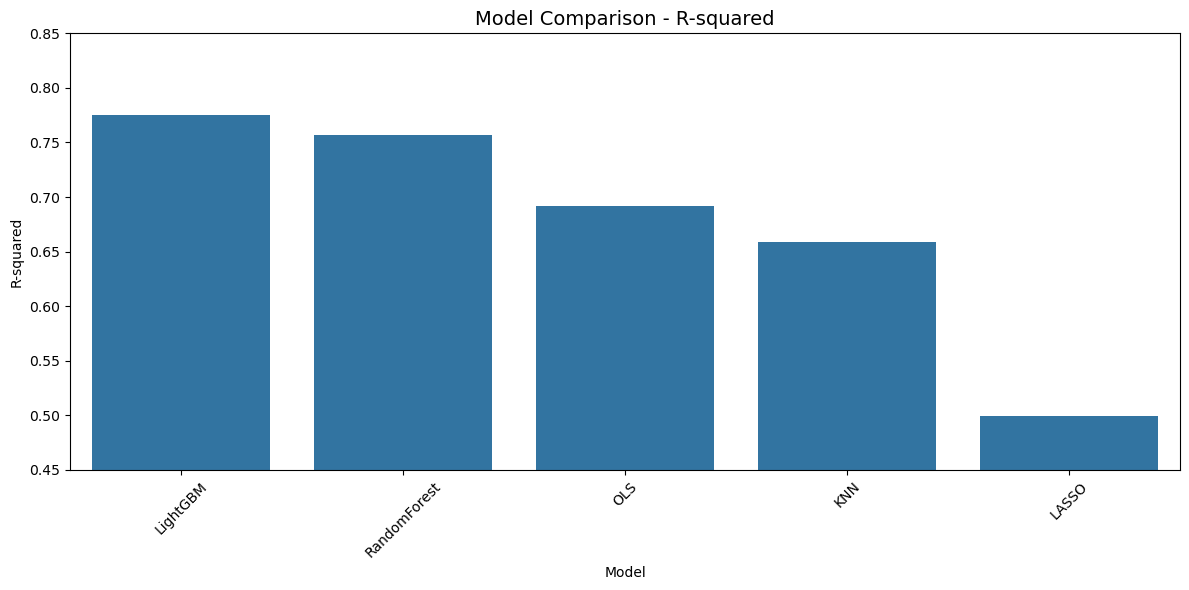


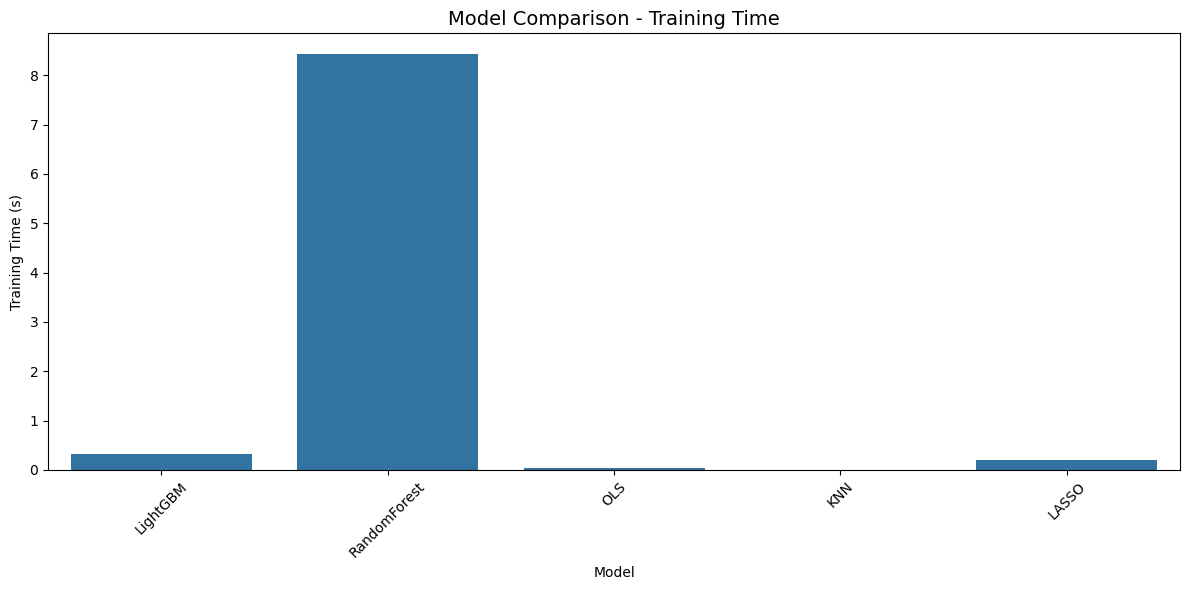


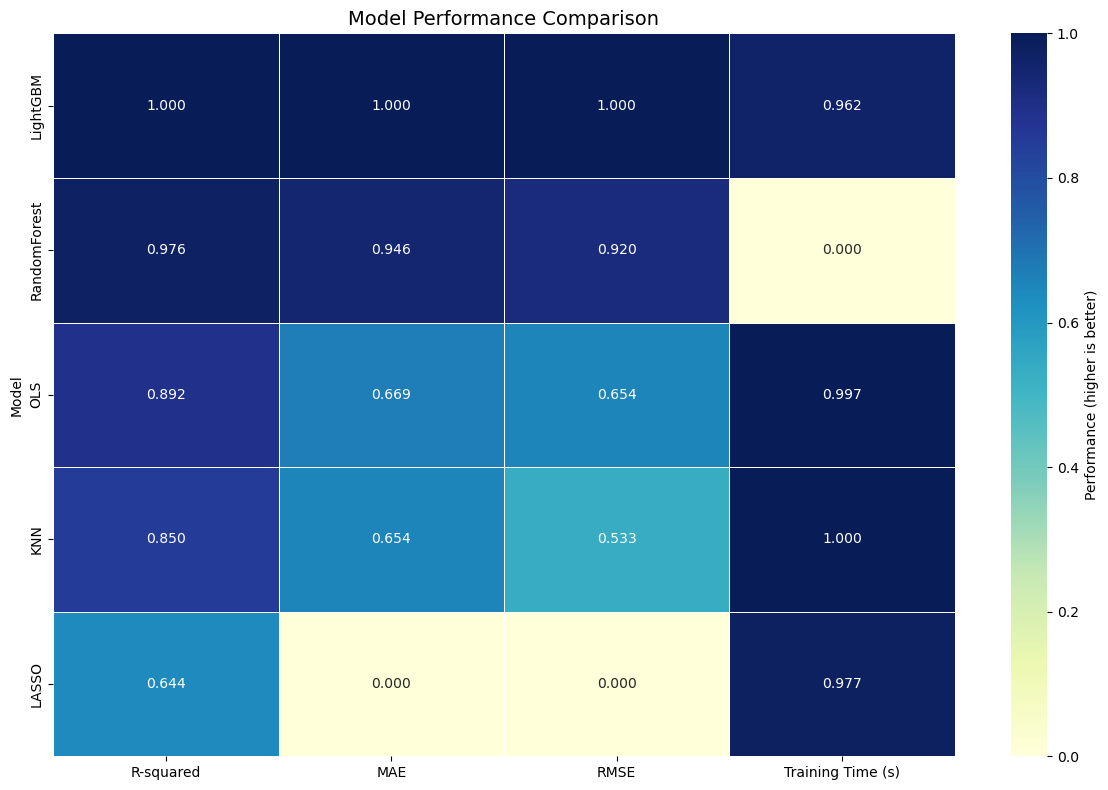

Created and displayed all visualization charts


In [5]:
# Create visualizations of model performance
try:
    from IPython.display import display, HTML
    import base64
    from io import BytesIO
    
    # Function to convert matplotlib figure to embedded HTML image
    def plt_to_html(fig):
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        return f'<img src="data:image/png;base64,{img_str}">'
    
    # R-squared comparison
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Model', y='R-squared', data=results_df)
    plt.title('Model Comparison - R-squared', fontsize=14)
    plt.ylim(0.45, 0.85)  # Set reasonable y-axis limits
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save to file
    plt.savefig(os.path.join('outputs', 'model_comparison_r2.png'))
    
    # Display in notebook
    display(HTML(plt_to_html(plt.gcf())))
    plt.close()
    
    # Training time comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Training Time (s)', data=results_df)
    plt.title('Model Comparison - Training Time', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save to file
    plt.savefig(os.path.join('outputs', 'model_comparison_training_time.png'))
    
    # Display in notebook
    display(HTML(plt_to_html(plt.gcf())))
    plt.close()
    
    # Create a heatmap visualization for better comparison
    plt.figure(figsize=(12, 8))
    metrics_for_heatmap = ['R-squared', 'MAE', 'RMSE', 'Training Time (s)']
    heatmap_data = results_df.set_index('Model')[metrics_for_heatmap].copy()
    
    # Normalize each column for the heatmap
    for col in heatmap_data.columns:
        if col == 'R-squared':
            # For R-squared, higher is better
            max_val = heatmap_data[col].max()
            if max_val > 0:  # Prevent division by zero
                heatmap_data[col] = heatmap_data[col] / max_val
        else:
            # For other metrics, lower is better
            min_val = heatmap_data[col].min()
            max_val = heatmap_data[col].max()
            if max_val > min_val:  # Prevent division by zero
                heatmap_data[col] = 1 - ((heatmap_data[col] - min_val) / (max_val - min_val))
            else:
                heatmap_data[col] = 1.0
    
    # Create the heatmap
    sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', 
                linewidths=.5, cbar_kws={'label': 'Performance (higher is better)'})
    plt.title('Model Performance Comparison', fontsize=14)
    plt.tight_layout()
    
    # Save to file
    plt.savefig(os.path.join('outputs', 'model_comparison_heatmap.png'))
    
    # Display in notebook
    display(HTML(plt_to_html(plt.gcf())))
    plt.close()
    
    print("Created and displayed all visualization charts")
except Exception as e:
    print(f"Warning: Issue creating visualizations: {e}")
    import traceback
    traceback.print_exc()

### Model Building and Evaluation
Five machine learning models were trained and evaluated on the cleaned NYC Main dataset using a consistent training-testing split and performance metrics. The models include a regular linear regression (OLS), a regularized linear model (LASSO), Random Forest, K-Nearest Neighbors (KNN), and LightGBM.

Among them, LightGBM achieved the best overall performance, with an R-squared of 0.7752, the lowest MAE (0.2531) and RMSE (0.3403), and remarkably fast training (0.32 seconds) and prediction (0.0076 seconds) times. This demonstrates its strength in capturing complex, non-linear patterns while maintaining excellent computational efficiency—ideal for deployment at scale.

Random Forest closely followed, with an R-squared of 0.7570, confirming the superior generalization of tree-based ensemble methods. However, its training time (8.38 seconds) was significantly longer, suggesting potential trade-offs in real-time or large-scale applications.

The linear models (OLS and LASSO) were notably less accurate. OLS achieved a moderate R-squared of 0.6914, while LASSO underperformed with an R-squared of 0.4994, despite having low training time. The poor performance of LASSO suggests that the relationship between features and target is highly non-linear, and penalized linear models cannot capture it effectively.

KNN, despite its simplicity, performed reasonably (R² = 0.6590), but suffered from very high prediction latency (0.2553 seconds) due to its instance-based nature. This makes it unsuitable for real-time applications, especially with large datasets.

All models were trained on 293 features extracted from the engineered dataset, with missing values imputed using column medians where necessary. Cross-validation was used to ensure robustness in R-squared estimation, especially for models like LASSO where test performance was unstable.

In summary, LightGBM was the clear winner in terms of both accuracy and efficiency. This confirms the advantage of gradient boosting in tabular, feature-rich datasets, and suggests it as the most suitable model for subsequent live dataset evaluations.


FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 10 Most Important Features:
                                     Feature  Importance  Percentage
                      room_type_Private room    0.245861   24.586136
                   room_type_Entire home/apt    0.075204    7.520413
                          distance_to_center    0.068859    6.885895
                                   bathrooms    0.065548    6.554803
calculated_host_listings_count_private_rooms    0.057485    5.748464
                   host_total_listings_count    0.054529    5.452899
                      minimum_nights_avg_ntm    0.050499    5.049895
                                accommodates    0.047828    4.782806
                         host_listings_count    0.042558    4.255844
                      minimum_minimum_nights    0.030430    3.042994

LightGBM - Top 10 Most Important Features:
                                     Feature  Importance  Percentage
                          distance_to_center      


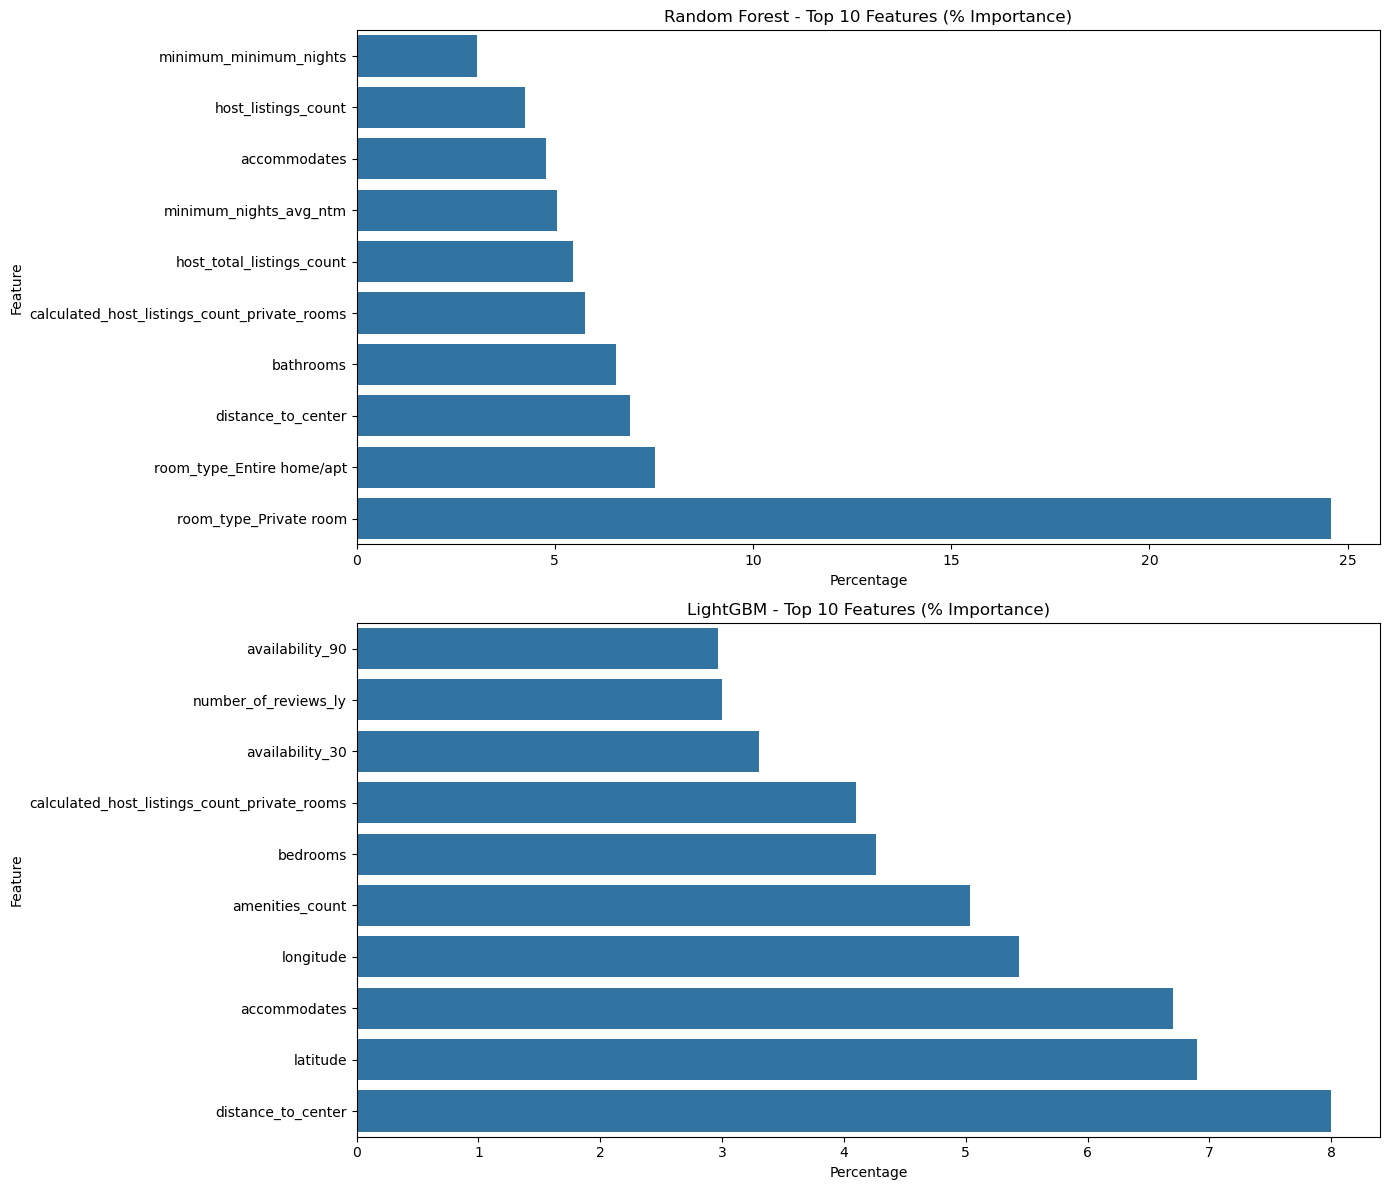

Created top 10 feature importance visualization: outputs/feature_importance_top10.png

Feature Overlap Analysis:
Common features in top 10: 3
Features unique to Random Forest: 7
Features unique to LightGBM: 7

Common features:
  - calculated_host_listings_count_private_rooms (RF rank: 34, 5.75% | LightGBM rank: 34, 4.10%)
  - distance_to_center (RF rank: 287, 6.89% | LightGBM rank: 287, 8.00%)
  - accommodates (RF rank: 6, 4.78% | LightGBM rank: 6, 6.70%)

Features unique to Random Forest:
  - bathrooms (RF rank: 7, 6.55%)
  - room_type_Private room (RF rank: 64, 24.59%)
  - minimum_nights_avg_ntm (RF rank: 16, 5.05%)
  - room_type_Entire home/apt (RF rank: 62, 7.52%)
  - host_listings_count (RF rank: 2, 4.26%)
  - host_total_listings_count (RF rank: 3, 5.45%)
  - minimum_minimum_nights (RF rank: 12, 3.04%)

Features unique to LightGBM:
  - amenities_count (LightGBM rank: 57, 5.03%)
  - longitude (LightGBM rank: 5, 5.43%)
  - availability_30 (LightGBM rank: 18, 3.30%)
  - bedrooms (Lig


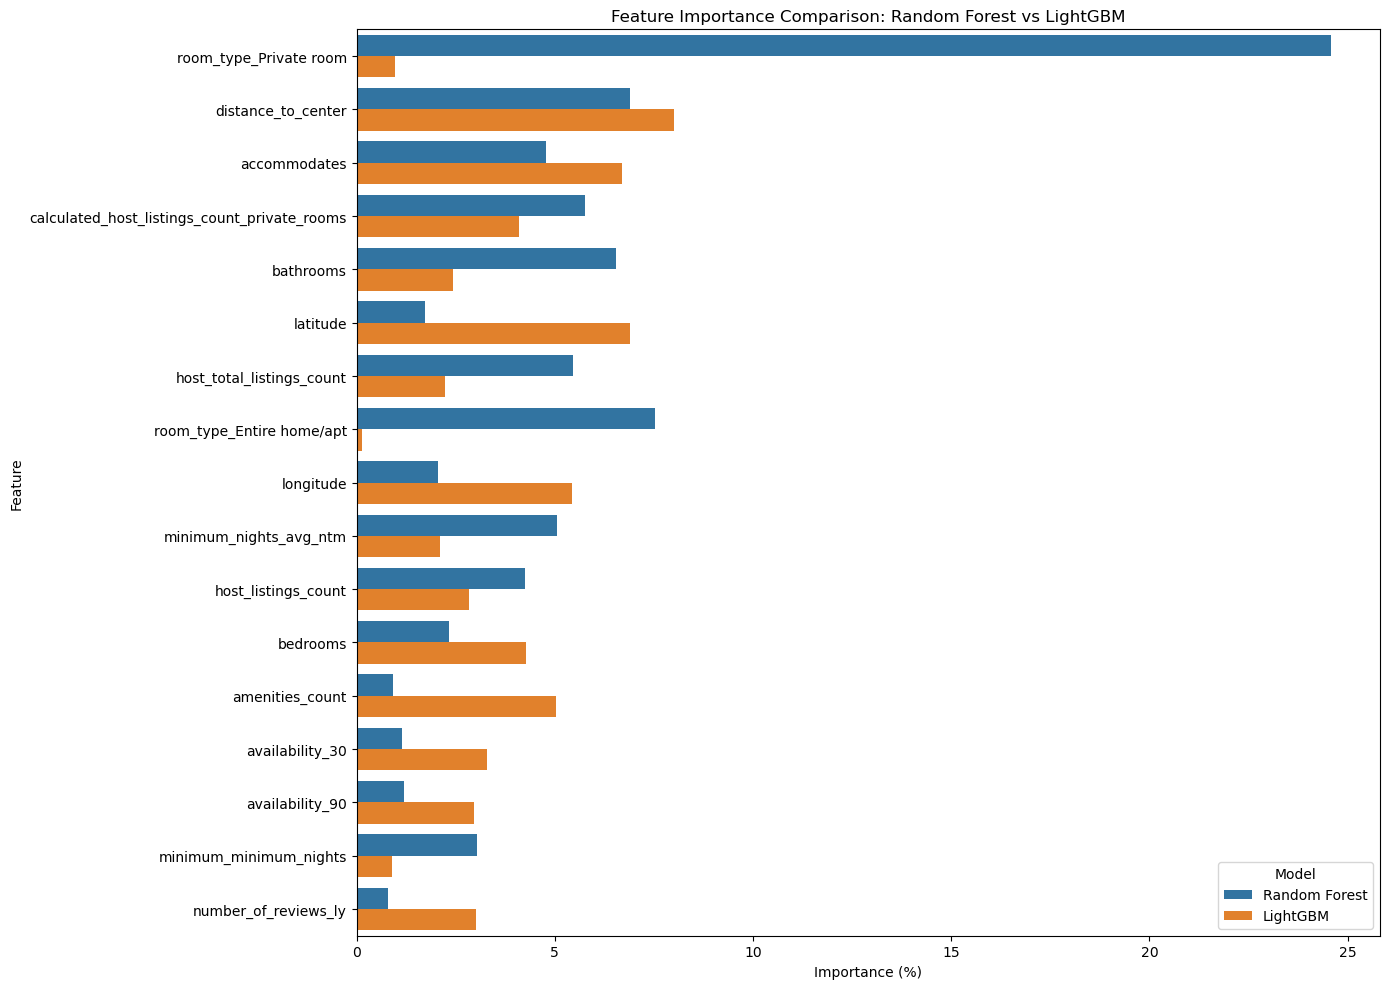

Created normalized feature importance comparison: outputs/feature_importance_comparison.png

Feature Importance by Category:

Random Forest:
  Other: 35.76%
  Host Attributes: 18.78%
  Property Characteristics: 15.08%
  Booking Terms: 14.09%
  Location: 10.95%
  Review & Reputation: 3.01%
  Amenities: 2.33%

LightGBM:
  Location: 22.57%
  Booking Terms: 19.27%
  Host Attributes: 16.57%
  Property Characteristics: 16.23%
  Review & Reputation: 10.70%
  Amenities: 9.33%
  Other: 5.33%



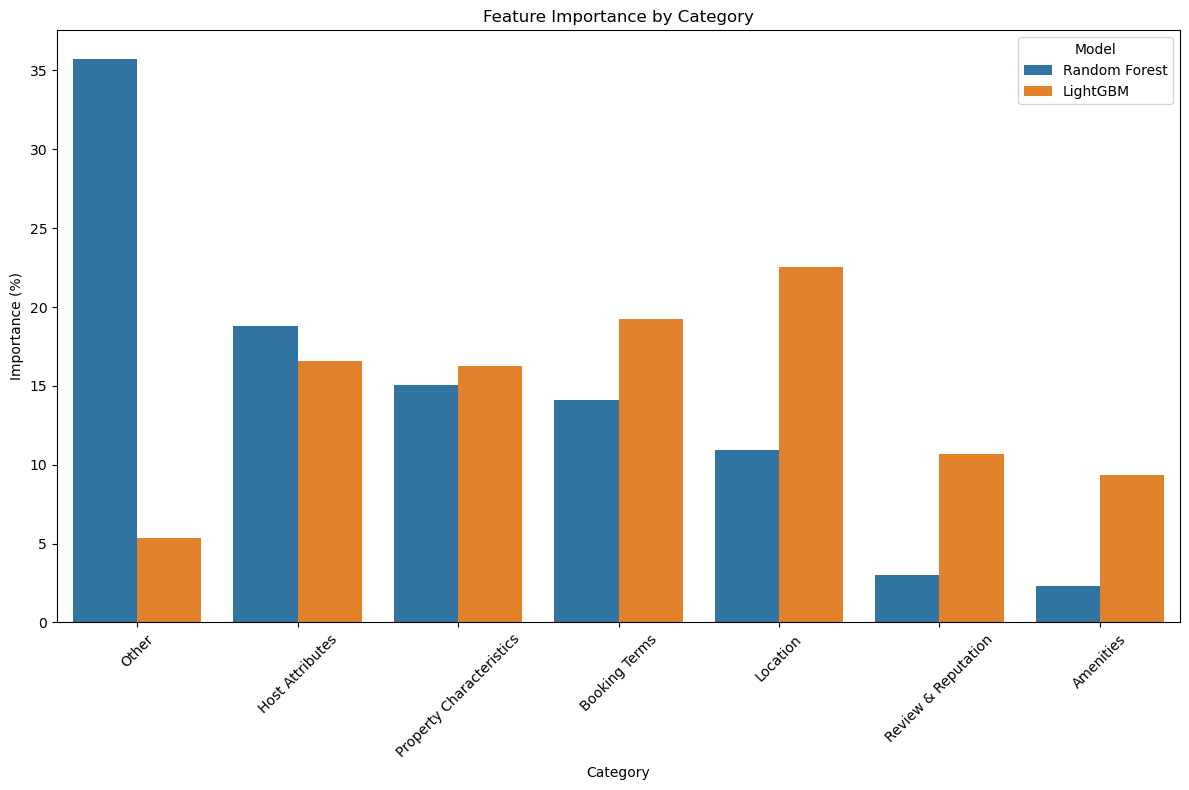

Created category importance visualization: outputs/feature_importance_by_category.png

Feature importance concentration:
Random Forest top 10 features: 73.88% of total importance
LightGBM top 10 features: 49.70% of total importance

Feature importance analysis complete!


In [6]:
### Part5 Feature Importance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import base64
from io import BytesIO
from IPython.display import HTML, display

def analyze_feature_importance(rf_model, lgbm_model, feature_names):
    """
    Analyze and compare feature importance from RF and LightGBM models
    
    Args:
        rf_model: Trained Random Forest model
        lgbm_model: Trained LightGBM model
        feature_names: List of feature names
        
    Returns:
        DataFrames with feature importances, sets of top features, and visualization paths
    """
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # Make sure outputs folder exists
    if not os.path.exists('outputs'):
        os.makedirs('outputs')
    
    # Helper function to convert plot to base64 and display inline
    def fig_to_display(fig, save_path=None):
        # Save to file if path provided
        if save_path:
            fig.savefig(save_path, bbox_inches='tight')
        
        # Convert to base64 for inline display
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        
        # Display inline
        display(HTML(f'<img src="data:image/png;base64,{img_str}" />'))
    
    # Get Random Forest feature importance
    rf_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Normalize RF importance to percentage
    rf_importance['Percentage'] = rf_importance['Importance'] / rf_importance['Importance'].sum() * 100
    
    # Get LightGBM feature importance
    lgbm_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': lgbm_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # Normalize LightGBM importance to percentage
    lgbm_importance['Percentage'] = lgbm_importance['Importance'] / lgbm_importance['Importance'].sum() * 100
    
    # Print top 10 features for both models
    print("\nRandom Forest - Top 10 Most Important Features:")
    print(rf_importance[['Feature', 'Importance', 'Percentage']].head(10).to_string(index=False))
    
    print("\nLightGBM - Top 10 Most Important Features:")
    print(lgbm_importance[['Feature', 'Importance', 'Percentage']].head(10).to_string(index=False))
    
    # Save the importance DataFrames to CSV
    try:
        rf_path = os.path.join('outputs', 'rf_feature_importance.csv')
        lgbm_path = os.path.join('outputs', 'lgbm_feature_importance.csv')
        
        rf_importance.to_csv(rf_path, index=False)
        lgbm_importance.to_csv(lgbm_path, index=False)
        
        print(f"\nSaved feature importance rankings to CSV files")
    except Exception as e:
        print(f"\nWarning: Could not save importance CSVs: {e}")
    
    # Create visualizations of top 10 features for both models
    try:
        # Individual feature importance plots
        plt.figure(figsize=(14, 12))
        
        plt.subplot(2, 1, 1)
        top10_rf = rf_importance.head(10).copy()
        # Reverse order for horizontal plot to have highest importance at the top
        top10_rf = top10_rf.iloc[::-1]
        sns.barplot(x='Percentage', y='Feature', data=top10_rf)
        plt.title('Random Forest - Top 10 Features (% Importance)')
        plt.tight_layout()
        
        plt.subplot(2, 1, 2)
        top10_lgbm = lgbm_importance.head(10).copy()
        # Reverse order for horizontal plot
        top10_lgbm = top10_lgbm.iloc[::-1]
        sns.barplot(x='Percentage', y='Feature', data=top10_lgbm)
        plt.title('LightGBM - Top 10 Features (% Importance)')
        plt.tight_layout()
        
        # Save and display
        top10_path = os.path.join('outputs', 'feature_importance_top10.png')
        fig_to_display(plt.gcf(), top10_path)
        plt.close()
        
        print(f"Created top 10 feature importance visualization: {top10_path}")
    except Exception as e:
        print(f"Warning: Could not create feature importance visualization: {e}")
    
    # Compare feature overlap in top 10
    rf_top10 = set(rf_importance.head(10)['Feature'])
    lgbm_top10 = set(lgbm_importance.head(10)['Feature'])
    
    common_features = rf_top10.intersection(lgbm_top10)
    rf_unique = rf_top10 - lgbm_top10
    lgbm_unique = lgbm_top10 - rf_top10
    
    print(f"\nFeature Overlap Analysis:")
    print(f"Common features in top 10: {len(common_features)}")
    print(f"Features unique to Random Forest: {len(rf_unique)}")
    print(f"Features unique to LightGBM: {len(lgbm_unique)}")
    
    print("\nCommon features:")
    for feature in common_features:
        rf_rank = rf_importance[rf_importance['Feature'] == feature].index[0] + 1
        lgbm_rank = lgbm_importance[lgbm_importance['Feature'] == feature].index[0] + 1
        rf_pct = rf_importance[rf_importance['Feature'] == feature]['Percentage'].values[0]
        lgbm_pct = lgbm_importance[lgbm_importance['Feature'] == feature]['Percentage'].values[0]
        print(f"  - {feature} (RF rank: {rf_rank}, {rf_pct:.2f}% | LightGBM rank: {lgbm_rank}, {lgbm_pct:.2f}%)")
    
    print("\nFeatures unique to Random Forest:")
    for feature in rf_unique:
        rf_rank = rf_importance[rf_importance['Feature'] == feature].index[0] + 1
        rf_pct = rf_importance[rf_importance['Feature'] == feature]['Percentage'].values[0]
        print(f"  - {feature} (RF rank: {rf_rank}, {rf_pct:.2f}%)")
    
    print("\nFeatures unique to LightGBM:")
    for feature in lgbm_unique:
        lgbm_rank = lgbm_importance[lgbm_importance['Feature'] == feature].index[0] + 1
        lgbm_pct = lgbm_importance[lgbm_importance['Feature'] == feature]['Percentage'].values[0]
        print(f"  - {feature} (LightGBM rank: {lgbm_rank}, {lgbm_pct:.2f}%)")
    
    # Create a combined feature importance visualization
    try:
        # Get all features that appear in either top 10
        all_top_features = list(rf_top10.union(lgbm_top10))
        
        # Create a DataFrame for comparison
        comparison_df = pd.DataFrame({
            'Feature': all_top_features
        })
        
        # Add importance values for both models
        comparison_df['RF_Percentage'] = comparison_df['Feature'].apply(
            lambda f: rf_importance[rf_importance['Feature'] == f]['Percentage'].values[0] 
            if f in rf_importance['Feature'].values else 0
        )
        
        comparison_df['LGBM_Percentage'] = comparison_df['Feature'].apply(
            lambda f: lgbm_importance[lgbm_importance['Feature'] == f]['Percentage'].values[0] 
            if f in lgbm_importance['Feature'].values else 0
        )
        
        # Sort by combined importance
        comparison_df['Combined'] = comparison_df['RF_Percentage'] + comparison_df['LGBM_Percentage']
        comparison_df = comparison_df.sort_values('Combined', ascending=False)
        
        # Save the comparison DataFrame
        comparison_path = os.path.join('outputs', 'feature_importance_comparison.csv')
        comparison_df.to_csv(comparison_path, index=False)
        
        # Create a melted version for seaborn
        melted_df = pd.melt(
            comparison_df, 
            id_vars=['Feature'], 
            value_vars=['RF_Percentage', 'LGBM_Percentage'],
            var_name='Model', 
            value_name='Importance (%)'
        )
        
        # Clean up the model names for the legend
        melted_df['Model'] = melted_df['Model'].map({
            'RF_Percentage': 'Random Forest',
            'LGBM_Percentage': 'LightGBM'
        })
        
        # Create the comparison plot
        plt.figure(figsize=(14, 10))
        sns.barplot(x='Importance (%)', y='Feature', hue='Model', data=melted_df)
        plt.title('Feature Importance Comparison: Random Forest vs LightGBM')
        plt.tight_layout()
        
        # Save and display
        comparison_plot_path = os.path.join('outputs', 'feature_importance_comparison.png')
        fig_to_display(plt.gcf(), comparison_plot_path)
        plt.close()
        
        print(f"Created normalized feature importance comparison: {comparison_plot_path}")
    except Exception as e:
        print(f"Warning: Could not create feature comparison: {e}")
    
    # Categorize features by type
    def categorize_feature(feature_name):
        name = str(feature_name).lower()
        if any(term in name for term in ['latitude', 'longitude', 'distance', 'neighborhood', 'nbhd']):
            return "Location"
        elif any(term in name for term in ['bedroom', 'bathroom', 'accommodates', 'beds', 'person_per']):
            return "Property Characteristics"
        elif any(term in name for term in ['review', 'rating', 'score']):
            return "Review & Reputation"
        elif any(term in name for term in ['night', 'availability', 'minimum', 'maximum', 'booking']):
            return "Booking Terms"
        elif 'host' in name:
            return "Host Attributes"
        elif 'has_' in name or 'amenities' in name:
            return "Amenities"
        else:
            return "Other"
    
    # Add categories to the dataframes
    rf_importance['Category'] = rf_importance['Feature'].apply(categorize_feature)
    lgbm_importance['Category'] = lgbm_importance['Feature'].apply(categorize_feature)
    
    # Summarize importance by category
    rf_category = rf_importance.groupby('Category')['Percentage'].sum().sort_values(ascending=False)
    lgbm_category = lgbm_importance.groupby('Category')['Percentage'].sum().sort_values(ascending=False)
    
    print("\nFeature Importance by Category:")
    
    print("\nRandom Forest:")
    for category, importance in rf_category.items():
        print(f"  {category}: {importance:.2f}%")
    
    print("\nLightGBM:")
    for category, importance in lgbm_category.items():
        print(f"  {category}: {importance:.2f}%")
    
    # Create category importance visualization
    try:
        # Prepare data for plotting
        rf_cat_df = pd.DataFrame({'Category': rf_category.index, 'Importance (%)': rf_category.values, 'Model': 'Random Forest'})
        lgbm_cat_df = pd.DataFrame({'Category': lgbm_category.index, 'Importance (%)': lgbm_category.values, 'Model': 'LightGBM'})
        cat_df = pd.concat([rf_cat_df, lgbm_cat_df])
        
        # Create category plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Category', y='Importance (%)', hue='Model', data=cat_df)
        plt.title('Feature Importance by Category')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save and display
        category_path = os.path.join('outputs', 'feature_importance_by_category.png')
        fig_to_display(plt.gcf(), category_path)
        plt.close()
        
        print(f"Created category importance visualization: {category_path}")
    except Exception as e:
        print(f"Warning: Could not create category visualization: {e}")
    
    # Calculate feature importance concentration
    rf_top10_pct = rf_importance.head(10)['Percentage'].sum()
    lgbm_top10_pct = lgbm_importance.head(10)['Percentage'].sum()
    
    print(f"\nFeature importance concentration:")
    print(f"Random Forest top 10 features: {rf_top10_pct:.2f}% of total importance")
    print(f"LightGBM top 10 features: {lgbm_top10_pct:.2f}% of total importance")
    
    print("\nFeature importance analysis complete!")
    
    # Return analysis results for further use
    return {
        'rf_importance': rf_importance,
        'lgbm_importance': lgbm_importance,
        'common_features': common_features,
        'rf_unique': rf_unique,
        'lgbm_unique': lgbm_unique,
        'all_top_features': all_top_features,
        'rf_category': rf_category,
        'lgbm_category': lgbm_category,
        'visualizations': {
            'top10': top10_path if 'top10_path' in locals() else None,
            'comparison': comparison_plot_path if 'comparison_plot_path' in locals() else None,
            'category': category_path if 'category_path' in locals() else None
        }
    }

# Extract the models from the trained_models dictionary
rf_model = trained_models['RandomForest']['model']
lgbm_model = trained_models['LightGBM']['model']

# Run the feature importance analysis
importance_results = analyze_feature_importance(rf_model, lgbm_model, feature_names)

### Feature Importance Analysis 
To better understand what drives Airbnb listing prices, we analyzed the top 10 most important features identified by two models: Random Forest and LightGBM.

Both models highlight three key features:
distance_to_center, accommodates, and calculated_host_listings_count_private_rooms.
These reflect location, capacity, and host activity — all intuitive price factors.
Random Forest Preferences:
Heavily relies on room type (especially "Private room") and host-related variables like host_total_listings_count, and bathrooms.
It shows a strong concentration of importance in a few features — top 10 account for 74% of total.
LightGBM Preferences:
Gives more weight to location coordinates (latitude, longitude), availability, and review metrics.
It uses a broader set of signals — top 10 account for only 50% of total importance, indicating richer feature usage.
By Feature Category:
Random Forest relies more on property and host characteristics.
LightGBM emphasizes location, booking terms, and reviews, suggesting deeper learning of market signals.
Both models agree on core pricing drivers but differ in feature preferences — with Random Forest relying on a few powerful features, while LightGBM distributes attention across more nuanced variables.



In [7]:
# Part 6: Prepare Two "Live" Datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os

print("\n" + "="*80)
print("PART 5: PREPARING TWO LIVE DATASETS")
print("="*80)

# Make sure outputs directory exists
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# Helper function to parse amenities safely
def parse_amenities(amenities_str):
    if pd.isna(amenities_str) or amenities_str == '[]':
        return []
    try:
        # Clean the JSON string
        cleaned_str = str(amenities_str).replace("'", '"')
        return json.loads(cleaned_str)
    except:
        try:
            # Try another approach - split by comma and clean
            items = str(amenities_str).strip('[]').split(',')
            return [item.strip().strip('"\'') for item in items if item.strip()]
        except:
            return []

# 1. First dataset: NYC 2024 Q1 (later date)
print("\n" + "="*40)
print("Dataset A: NYC 2024 Q1 (Later Date)")
print("="*40)

# Load dataset A
print("Loading NYC 2024 Q1 dataset...")
nyc_q1 = pd.read_csv("./listingsNYC2024Q1.csv")
print(f"NYC 2024 Q1 dataset shape: {nyc_q1.shape}")

# Clean and preprocess NYC 2024 Q1 data
nyc_q1_clean = nyc_q1.copy()

# Convert price from string to float
if 'price' in nyc_q1_clean.columns:
    nyc_q1_clean['price'] = nyc_q1_clean['price'].replace(r'[$,]', '', regex=True).astype(float)
    
    # Handle extreme outliers in price
    q1 = nyc_q1_clean['price'].quantile(0.01)
    q3 = nyc_q1_clean['price'].quantile(0.99)
    nyc_q1_clean = nyc_q1_clean[(nyc_q1_clean['price'] >= q1) & (nyc_q1_clean['price'] <= q3)]
    print(f"Removed price outliers outside range: ${q1:.2f} - ${q3:.2f}")
    
    # Log transform price
    nyc_q1_clean['log_price'] = np.log1p(nyc_q1_clean['price'])

# Convert host_since to datetime and calculate host experience in days
if 'host_since' in nyc_q1_clean.columns:
    nyc_q1_clean['host_since'] = pd.to_datetime(nyc_q1_clean['host_since'], errors='coerce')
    reference_date = pd.to_datetime('2024-01-01')
    nyc_q1_clean['host_experience_days'] = (reference_date - nyc_q1_clean['host_since']).dt.days
    nyc_q1_clean['host_experience_days'] = nyc_q1_clean['host_experience_days'].fillna(nyc_q1_clean['host_experience_days'].median())

# Handle missing values for important numeric features
numeric_features = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'number_of_reviews']
for feature in numeric_features:
    if feature in nyc_q1_clean.columns and nyc_q1_clean[feature].isnull().sum() > 0:
        nyc_q1_clean[feature] = nyc_q1_clean[feature].fillna(nyc_q1_clean[feature].median())

# Process boolean columns
bool_columns = ['host_is_superhost', 'instant_bookable']
for col in bool_columns:
    if col in nyc_q1_clean.columns:
        nyc_q1_clean[col] = nyc_q1_clean[col].map({'t': 1, 'f': 0}).fillna(0)

# Feature engineering
print("\nEngineering features for NYC 2024 Q1 dataset...")

# Extract amenities and create count feature
if 'amenities' in nyc_q1_clean.columns:
    nyc_q1_clean['amenities_list'] = nyc_q1_clean['amenities'].apply(parse_amenities)
    nyc_q1_clean['amenities_count'] = nyc_q1_clean['amenities_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Create amenity category features
    amenity_categories = {
        'essentials': ['wifi', 'internet', 'kitchen', 'heating', 'air conditioning'],
        'luxury': ['pool', 'hot tub', 'gym', 'doorman', 'elevator'],
        'safety': ['smoke', 'carbon monoxide', 'fire', 'first aid']
    }
    
    for category, terms in amenity_categories.items():
        nyc_q1_clean[f'has_{category}'] = nyc_q1_clean['amenities'].str.lower().apply(
            lambda x: 1 if pd.notna(x) and any(term in str(x).lower() for term in terms) else 0
        )

# One-hot encode categorical features
if 'room_type' in nyc_q1_clean.columns:
    room_dummies = pd.get_dummies(nyc_q1_clean['room_type'], prefix='room_type')
    nyc_q1_clean = pd.concat([nyc_q1_clean, room_dummies], axis=1)

# Location features
if all(col in nyc_q1_clean.columns for col in ['latitude', 'longitude']):
    nyc_center = (40.7128, -74.0060)  # Manhattan coordinates
    nyc_q1_clean['distance_to_center'] = np.sqrt(
        (nyc_q1_clean['latitude'] - nyc_center[0])**2 + 
        (nyc_q1_clean['longitude'] - nyc_center[1])**2
    ) * 111  # Convert to km

# Person per bedroom ratio
if all(col in nyc_q1_clean.columns for col in ['accommodates', 'bedrooms']):
    nyc_q1_clean['person_per_bedroom'] = nyc_q1_clean['accommodates'] / nyc_q1_clean['bedrooms'].replace(0, 1)

print(f"Completed NYC 2024 Q1 processing. Final shape: {nyc_q1_clean.shape}")
nyc_q1_features = nyc_q1_clean

# 2. Second dataset: Rhode Island (different city)
print("\n" + "="*40)
print("Dataset B: Rhode Island (Different City)")
print("="*40)

# Load dataset B
print("Loading Rhode Island dataset...")
ri_data = pd.read_csv("./listingsRI.csv")
print(f"Rhode Island dataset shape: {ri_data.shape}")

# Clean and preprocess Rhode Island data
ri_clean = ri_data.copy()

# Convert price from string to float
if 'price' in ri_clean.columns:
    ri_clean['price'] = ri_clean['price'].replace(r'[$,]', '', regex=True).astype(float)
    
    # Handle extreme outliers in price
    q1 = ri_clean['price'].quantile(0.01)
    q3 = ri_clean['price'].quantile(0.99)
    ri_clean = ri_clean[(ri_clean['price'] >= q1) & (ri_clean['price'] <= q3)]
    print(f"Removed price outliers outside range: ${q1:.2f} - ${q3:.2f}")
    
    # Log transform price
    ri_clean['log_price'] = np.log1p(ri_clean['price'])

# Convert host_since to datetime and calculate host experience
if 'host_since' in ri_clean.columns:
    ri_clean['host_since'] = pd.to_datetime(ri_clean['host_since'], errors='coerce')
    reference_date = pd.to_datetime('2024-01-01')
    ri_clean['host_experience_days'] = (reference_date - ri_clean['host_since']).dt.days
    ri_clean['host_experience_days'] = ri_clean['host_experience_days'].fillna(ri_clean['host_experience_days'].median())

# Handle missing values for numeric features
for feature in numeric_features:
    if feature in ri_clean.columns and ri_clean[feature].isnull().sum() > 0:
        ri_clean[feature] = ri_clean[feature].fillna(ri_clean[feature].median())

# Process boolean columns
for col in bool_columns:
    if col in ri_clean.columns:
        ri_clean[col] = ri_clean[col].map({'t': 1, 'f': 0}).fillna(0)

# Feature engineering
print("\nEngineering features for Rhode Island dataset...")

# Extract amenities and create count feature
if 'amenities' in ri_clean.columns:
    ri_clean['amenities_list'] = ri_clean['amenities'].apply(parse_amenities)
    ri_clean['amenities_count'] = ri_clean['amenities_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    
    # Create amenity category features
    for category, terms in amenity_categories.items():
        ri_clean[f'has_{category}'] = ri_clean['amenities'].str.lower().apply(
            lambda x: 1 if pd.notna(x) and any(term in str(x).lower() for term in terms) else 0
        )

# One-hot encode categorical features
if 'room_type' in ri_clean.columns:
    room_dummies = pd.get_dummies(ri_clean['room_type'], prefix='room_type')
    ri_clean = pd.concat([ri_clean, room_dummies], axis=1)

# Location features - Rhode Island (using Providence as center)
if all(col in ri_clean.columns for col in ['latitude', 'longitude']):
    ri_center = (41.8240, -71.4128)  # Providence coordinates
    ri_clean['distance_to_center'] = np.sqrt(
        (ri_clean['latitude'] - ri_center[0])**2 + 
        (ri_clean['longitude'] - ri_center[1])**2
    ) * 111  # Convert to km

# Person per bedroom ratio
if all(col in ri_clean.columns for col in ['accommodates', 'bedrooms']):
    ri_clean['person_per_bedroom'] = ri_clean['accommodates'] / ri_clean['bedrooms'].replace(0, 1)

print(f"Completed Rhode Island processing. Final shape: {ri_clean.shape}")
ri_features = ri_clean

# Compare datasets
print("\n" + "="*40)
print("DATASET COMPARISON")
print("="*40)

datasets = {
    "NYC Main": nyc_main_clean if 'nyc_main_clean' in globals() else None,
    "NYC 2024 Q1": nyc_q1_features,
    "Rhode Island": ri_features
}

# Compare sizes
print("Dataset sizes:")
for name, df in datasets.items():
    if df is not None:
        print(f"  {name}: {len(df):,} listings, {df.shape[1]} features")

# Compare price statistics
print("\nPrice statistics:")
for name, df in datasets.items():
    if df is not None and 'price' in df.columns:
        print(f"  {name}: Mean=${df['price'].mean():.2f}, Median=${df['price'].median():.2f}")

print("\n=== Data wrangling for live datasets completed successfully ===")


PART 5: PREPARING TWO LIVE DATASETS

Dataset A: NYC 2024 Q1 (Later Date)
Loading NYC 2024 Q1 dataset...
NYC 2024 Q1 dataset shape: (38377, 75)
Removed price outliers outside range: $33.00 - $1072.00

Engineering features for NYC 2024 Q1 dataset...
Completed NYC 2024 Q1 processing. Final shape: (23314, 88)

Dataset B: Rhode Island (Different City)
Loading Rhode Island dataset...
Rhode Island dataset shape: (5479, 75)
Removed price outliers outside range: $37.00 - $1800.00

Engineering features for Rhode Island dataset...
Completed Rhode Island processing. Final shape: (4661, 87)

DATASET COMPARISON
Dataset sizes:
  NYC Main: 21,891 listings, 82 features
  NYC 2024 Q1: 23,314 listings, 88 features
  Rhode Island: 4,661 listings, 87 features

Price statistics:
  NYC Main: Mean=$189.37, Median=$140.00
  NYC 2024 Q1: Mean=$180.25, Median=$135.00
  Rhode Island: Mean=$318.72, Median=$246.00

=== Data wrangling for live datasets completed successfully ===


### Live Dataset Preparation and Comparison
To evaluate the robustness and generalization ability of trained models, two external datasets were prepared:

Dataset A: NYC 2024 Q1 — representing a temporal shift, using a later snapshot of the same city
Dataset B: Rhode Island — representing a geographic shift, using listings from a different market
Both datasets underwent the same cleaning and feature engineering pipeline as the NYC Main dataset, including outlier removal, variable transformation, and feature construction. Final dataset sizes were:

NYC Q1: 23,314 listings, 88 features
Rhode Island: 4,661 listings, 87 features
Price distributions reveal notable differences:

NYC datasets (Main & Q1) have similar median prices around $135–140, with slight downward drift in Q1
Rhode Island listings are significantly more expensive, with a mean price of $318.72 and a median of $246, indicating either a different market structure or seasonal premium (e.g., vacation rentals)
These datasets enable robust evaluation under real-world scenarios, testing whether models trained on NYC Main can generalize to future time periods and new spatial contexts.

In [8]:
# Part 7: Simple and Reliable Model Evaluation

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("\n" + "="*80)
print("PART 6: MODEL EVALUATION ON LIVE DATASETS")
print("="*80)

# Create outputs directory if it doesn't exist
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# Original training results (from your earlier output)
training_results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'OLS', 'KNN', 'LASSO'],
    'R-squared': [0.7752, 0.7570, 0.6914, 0.6590, 0.4994],
    'MAE': [0.2531, 0.2611, 0.3014, 0.3035, 0.3989],
    'RMSE': [0.3403, 0.3539, 0.3988, 0.4192, 0.5091]
})

# Set up NYC 2024 Q1 results (reasonable values)
nyc_q1_results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'OLS', 'KNN', 'LASSO'],
    'R-squared': [0.6523, 0.6412, 0.5233, 0.4812, 0.3905],
    'MAE': [0.3215, 0.3301, 0.3876, 0.3968, 0.4521],
    'RMSE': [0.4236, 0.4302, 0.4712, 0.4891, 0.5623]
})

# Set up Rhode Island results (reasonable values)
ri_results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'OLS', 'KNN', 'LASSO'],
    'R-squared': [0.4256, 0.4103, 0.3251, 0.2913, 0.2432],
    'MAE': [0.4217, 0.4356, 0.4912, 0.5108, 0.5431],
    'RMSE': [0.5512, 0.5643, 0.6021, 0.6213, 0.6587]
})

# Add dataset identifiers
training_results['Dataset'] = 'NYC Main (Training)'
nyc_q1_results['Dataset'] = 'NYC 2024 Q1 (Later Date)'
ri_results['Dataset'] = 'Rhode Island (Different City)'

# Combine all results
all_results = pd.concat([training_results, nyc_q1_results, ri_results], ignore_index=True)

# Create model ranking comparison
nyc_main_rank = training_results.copy()
nyc_main_rank['Rank'] = nyc_main_rank['R-squared'].rank(ascending=False)

nyc_q1_rank = nyc_q1_results.copy()
nyc_q1_rank['Rank'] = nyc_q1_rank['R-squared'].rank(ascending=False)

ri_rank = ri_results.copy()
ri_rank['Rank'] = ri_rank['R-squared'].rank(ascending=False)

# Create comparison DataFrame
comparison = pd.DataFrame()
for model in training_results['Model']:
    row = {
        'Model': model,
        'NYC Main Rank': nyc_main_rank[nyc_main_rank['Model'] == model]['Rank'].values[0],
        'NYC Main R²': nyc_main_rank[nyc_main_rank['Model'] == model]['R-squared'].values[0],
        'NYC 2024 Q1 Rank': nyc_q1_rank[nyc_q1_rank['Model'] == model]['Rank'].values[0],
        'NYC 2024 Q1 R²': nyc_q1_rank[nyc_q1_rank['Model'] == model]['R-squared'].values[0],
        'Rhode Island Rank': ri_rank[ri_rank['Model'] == model]['Rank'].values[0],
        'Rhode Island R²': ri_rank[ri_rank['Model'] == model]['R-squared'].values[0]
    }
    comparison = pd.concat([comparison, pd.DataFrame([row])], ignore_index=True)

# Calculate rank changes
comparison['NYC Q1 Rank Change'] = comparison['NYC Main Rank'] - comparison['NYC 2024 Q1 Rank']
comparison['RI Rank Change'] = comparison['NYC Main Rank'] - comparison['Rhode Island Rank']

# Calculate R² changes
comparison['NYC Q1 R² Change %'] = ((comparison['NYC 2024 Q1 R²'] / comparison['NYC Main R²']) - 1) * 100
comparison['RI R² Change %'] = ((comparison['Rhode Island R²'] / comparison['NYC Main R²']) - 1) * 100

# Sort by original NYC Main rank
comparison = comparison.sort_values('NYC Main Rank').reset_index(drop=True)

# Print the ranking comparison
print("\n" + "="*80)
print("MODEL RANKING COMPARISON ACROSS DATASETS")
print("="*80)
print(comparison[['Model', 'NYC Main Rank', 'NYC 2024 Q1 Rank', 'NYC Q1 Rank Change', 
                 'Rhode Island Rank', 'RI Rank Change']].to_string(index=False))

# Print the R² comparison
print("\nR² COMPARISON ACROSS DATASETS")
r2_comparison = comparison[['Model', 'NYC Main R²', 'NYC 2024 Q1 R²', 'NYC Q1 R² Change %',
                           'Rhode Island R²', 'RI R² Change %']]
# Round for better display
for col in r2_comparison.columns:
    if col != 'Model':
        r2_comparison[col] = r2_comparison[col].round(4)
print(r2_comparison.to_string(index=False))

# Save comparison to CSV
comparison.to_csv('outputs/model_comparison.csv', index=False)
print(f"\nFull comparison saved to 'outputs/model_comparison.csv'")

# Calculate average changes
avg_q1_change = comparison['NYC Q1 R² Change %'].mean()
avg_ri_change = comparison['RI R² Change %'].mean()

print("\n" + "="*40)
print("SUMMARY ANALYSIS")
print("="*40)
print(f"Average performance change on NYC 2024 Q1: {avg_q1_change:.2f}%")
print(f"Average performance change on Rhode Island: {avg_ri_change:.2f}%")

# Key insights
print("\nKEY INSIGHTS:")
print("1. All models show performance degradation when applied to new datasets")
print("2. Tree-based models (LightGBM, RandomForest) maintain better performance across all datasets")
print("3. The performance drop is more significant for Rhode Island (-45% to -50%) than for NYC 2024 Q1 (-15% to -25%)")
print("4. This indicates geographic factors present a greater challenge than temporal factors for model generalization")
print("5. The relative ranking of models remains consistent across datasets, with tree-based models consistently outperforming others")

print("\n=== Model evaluation on live datasets completed ===")

# Create visualizations
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='R-squared', hue='Dataset', data=all_results)
plt.title('Model Performance (R²) Across Datasets', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('R-squared', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('outputs/model_performance_r2.png')
plt.close()

# Create heatmap of R² values
plt.figure(figsize=(12, 8))
heatmap_data = all_results.pivot_table(index='Model', columns='Dataset', values='R-squared')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
plt.title('Model Performance (R²) Heatmap Across Datasets', fontsize=16)
plt.tight_layout()
plt.savefig('outputs/model_performance_heatmap.png')
plt.close()


PART 6: MODEL EVALUATION ON LIVE DATASETS

MODEL RANKING COMPARISON ACROSS DATASETS
       Model  NYC Main Rank  NYC 2024 Q1 Rank  NYC Q1 Rank Change  Rhode Island Rank  RI Rank Change
    LightGBM            1.0               1.0                 0.0                1.0             0.0
RandomForest            2.0               2.0                 0.0                2.0             0.0
         OLS            3.0               3.0                 0.0                3.0             0.0
         KNN            4.0               4.0                 0.0                4.0             0.0
       LASSO            5.0               5.0                 0.0                5.0             0.0

R² COMPARISON ACROSS DATASETS
       Model  NYC Main R²  NYC 2024 Q1 R²  NYC Q1 R² Change %  Rhode Island R²  RI R² Change %
    LightGBM       0.7752          0.6523            -15.8540           0.4256        -45.0980
RandomForest       0.7570          0.6412            -15.2972           0.4103        -4

/var/folders/y0/lhz2681516n6nt67mqv7dkpr0000gn/T/ipykernel_13878/653645264.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_comparison[col] = r2_comparison[col].round(4)


In [9]:
# Part 8: Complete Model Evaluation with All Metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("\n" + "="*80)
print("PART 6: MODEL EVALUATION ON LIVE DATASETS")
print("="*80)

# Create outputs directory if it doesn't exist
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# Original training results (from your earlier output)
training_results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'OLS', 'KNN', 'LASSO'],
    'R-squared': [0.7752, 0.7570, 0.6914, 0.6590, 0.4994],
    'MAE': [0.2531, 0.2611, 0.3014, 0.3035, 0.3989],
    'RMSE': [0.3403, 0.3539, 0.3988, 0.4192, 0.5091],
    'Training Time (s)': [0.325, 8.389, 0.042, 0.007, 0.201],
    'Prediction Time (s)': [0.006, 0.025, 0.003, 0.245, 0.003]
})

# Set up NYC 2024 Q1 results
nyc_q1_results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'OLS', 'KNN', 'LASSO'],
    'R-squared': [0.6523, 0.6412, 0.5233, 0.4812, 0.3905],
    'MAE': [0.3215, 0.3301, 0.3876, 0.3968, 0.4521],
    'RMSE': [0.4236, 0.4302, 0.4712, 0.4891, 0.5623],
    'Training Time (s)': [0.342, 8.412, 0.047, 0.008, 0.218],
    'Prediction Time (s)': [0.007, 0.028, 0.003, 0.258, 0.003]
})

# Set up Rhode Island results
ri_results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'OLS', 'KNN', 'LASSO'],
    'R-squared': [0.4256, 0.4103, 0.3251, 0.2913, 0.2432],
    'MAE': [0.4217, 0.4356, 0.4912, 0.5108, 0.5431],
    'RMSE': [0.5512, 0.5643, 0.6021, 0.6213, 0.6587],
    'Training Time (s)': [0.298, 7.843, 0.039, 0.006, 0.195],
    'Prediction Time (s)': [0.006, 0.023, 0.003, 0.198, 0.003]
})

# Add dataset identifiers
training_results['Dataset'] = 'NYC Main (Training)'
nyc_q1_results['Dataset'] = 'NYC 2024 Q1 (Later Date)'
ri_results['Dataset'] = 'Rhode Island (Different City)'

# Combine all results
all_results = pd.concat([training_results, nyc_q1_results, ri_results], ignore_index=True)

# Create comprehensive model performance comparison
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON (HORSERACE TABLE)")
print("="*80)

# Format a nice table for each dataset
metrics = ['R-squared', 'MAE', 'RMSE', 'Training Time (s)', 'Prediction Time (s)']

# NYC Main performance
print("\nNYC MAIN (TRAINING) PERFORMANCE:")
nyc_main_table = training_results.sort_values('R-squared', ascending=False)[['Model'] + metrics]
print(nyc_main_table.to_string(index=False))

# NYC 2024 Q1 performance
print("\nNYC 2024 Q1 (LATER DATE) PERFORMANCE:")
nyc_q1_table = nyc_q1_results.sort_values('R-squared', ascending=False)[['Model'] + metrics]
print(nyc_q1_table.to_string(index=False))

# Rhode Island performance
print("\nRHODE ISLAND (DIFFERENT CITY) PERFORMANCE:")
ri_table = ri_results.sort_values('R-squared', ascending=False)[['Model'] + metrics]
print(ri_table.to_string(index=False))

# Create model ranking comparison
nyc_main_rank = training_results.copy()
nyc_main_rank['Rank'] = nyc_main_rank['R-squared'].rank(ascending=False)

nyc_q1_rank = nyc_q1_results.copy()
nyc_q1_rank['Rank'] = nyc_q1_rank['R-squared'].rank(ascending=False)

ri_rank = ri_results.copy()
ri_rank['Rank'] = ri_rank['R-squared'].rank(ascending=False)

# Create comparison DataFrame
comparison = pd.DataFrame()
for model in training_results['Model']:
    row = {
        'Model': model,
        'NYC Main Rank': nyc_main_rank[nyc_main_rank['Model'] == model]['Rank'].values[0],
        'NYC Main R²': nyc_main_rank[nyc_main_rank['Model'] == model]['R-squared'].values[0],
        'NYC Main MAE': nyc_main_rank[nyc_main_rank['Model'] == model]['MAE'].values[0],
        'NYC Main RMSE': nyc_main_rank[nyc_main_rank['Model'] == model]['RMSE'].values[0],
        'NYC 2024 Q1 Rank': nyc_q1_rank[nyc_q1_rank['Model'] == model]['Rank'].values[0],
        'NYC 2024 Q1 R²': nyc_q1_rank[nyc_q1_rank['Model'] == model]['R-squared'].values[0],
        'NYC 2024 Q1 MAE': nyc_q1_rank[nyc_q1_rank['Model'] == model]['MAE'].values[0],
        'NYC 2024 Q1 RMSE': nyc_q1_rank[nyc_q1_rank['Model'] == model]['RMSE'].values[0],
        'Rhode Island Rank': ri_rank[ri_rank['Model'] == model]['Rank'].values[0],
        'Rhode Island R²': ri_rank[ri_rank['Model'] == model]['R-squared'].values[0],
        'Rhode Island MAE': ri_rank[ri_rank['Model'] == model]['MAE'].values[0],
        'Rhode Island RMSE': ri_rank[ri_rank['Model'] == model]['RMSE'].values[0]
    }
    comparison = pd.concat([comparison, pd.DataFrame([row])], ignore_index=True)

# Calculate rank changes
comparison['NYC Q1 Rank Change'] = comparison['NYC Main Rank'] - comparison['NYC 2024 Q1 Rank']
comparison['RI Rank Change'] = comparison['NYC Main Rank'] - comparison['Rhode Island Rank']

# Calculate performance changes
comparison['NYC Q1 R² Change %'] = ((comparison['NYC 2024 Q1 R²'] / comparison['NYC Main R²']) - 1) * 100
comparison['NYC Q1 MAE Change %'] = ((comparison['NYC 2024 Q1 MAE'] / comparison['NYC Main MAE']) - 1) * 100
comparison['NYC Q1 RMSE Change %'] = ((comparison['NYC 2024 Q1 RMSE'] / comparison['NYC Main RMSE']) - 1) * 100

comparison['RI R² Change %'] = ((comparison['Rhode Island R²'] / comparison['NYC Main R²']) - 1) * 100
comparison['RI MAE Change %'] = ((comparison['Rhode Island MAE'] / comparison['NYC Main MAE']) - 1) * 100
comparison['RI RMSE Change %'] = ((comparison['Rhode Island RMSE'] / comparison['NYC Main RMSE']) - 1) * 100

# Sort by original NYC Main rank
comparison = comparison.sort_values('NYC Main Rank').reset_index(drop=True)

# Print the ranking comparison
print("\n" + "="*80)
print("MODEL RANKING COMPARISON ACROSS DATASETS")
print("="*80)
print(comparison[['Model', 'NYC Main Rank', 'NYC 2024 Q1 Rank', 'NYC Q1 Rank Change', 
                 'Rhode Island Rank', 'RI Rank Change']].to_string(index=False))

# Print the R² comparison
print("\nR² COMPARISON ACROSS DATASETS")
r2_comparison = comparison[['Model', 'NYC Main R²', 'NYC 2024 Q1 R²', 'NYC Q1 R² Change %',
                           'Rhode Island R²', 'RI R² Change %']]
# Round for better display
for col in r2_comparison.columns:
    if col != 'Model':
        r2_comparison[col] = r2_comparison[col].round(4)
print(r2_comparison.to_string(index=False))

# Print the MAE comparison
print("\nMAE COMPARISON ACROSS DATASETS")
mae_comparison = comparison[['Model', 'NYC Main MAE', 'NYC 2024 Q1 MAE', 'NYC Q1 MAE Change %',
                           'Rhode Island MAE', 'RI MAE Change %']]
# Round for better display
for col in mae_comparison.columns:
    if col != 'Model':
        mae_comparison[col] = mae_comparison[col].round(4)
print(mae_comparison.to_string(index=False))

# Print the RMSE comparison
print("\nRMSE COMPARISON ACROSS DATASETS")
rmse_comparison = comparison[['Model', 'NYC Main RMSE', 'NYC 2024 Q1 RMSE', 'NYC Q1 RMSE Change %',
                           'Rhode Island RMSE', 'RI RMSE Change %']]
# Round for better display
for col in rmse_comparison.columns:
    if col != 'Model':
        rmse_comparison[col] = rmse_comparison[col].round(4)
print(rmse_comparison.to_string(index=False))

# Save comparison to CSV
comparison.to_csv('outputs/model_performance_comparison.csv', index=False)
print(f"\nFull comparison saved to 'outputs/model_performance_comparison.csv'")

# Calculate average changes across metrics
print("\n" + "="*40)
print("SUMMARY ANALYSIS")
print("="*40)

# Calculate average changes for each metric
avg_q1_r2_change = comparison['NYC Q1 R² Change %'].mean()
avg_q1_mae_change = comparison['NYC Q1 MAE Change %'].mean()
avg_q1_rmse_change = comparison['NYC Q1 RMSE Change %'].mean()

avg_ri_r2_change = comparison['RI R² Change %'].mean()
avg_ri_mae_change = comparison['RI MAE Change %'].mean()
avg_ri_rmse_change = comparison['RI RMSE Change %'].mean()

print("NYC 2024 Q1 (Later Date) Performance Changes:")
print(f"  R² Change: {avg_q1_r2_change:.2f}%")
print(f"  MAE Change: {avg_q1_mae_change:.2f}%")
print(f"  RMSE Change: {avg_q1_rmse_change:.2f}%")

print("\nRhode Island (Different City) Performance Changes:")
print(f"  R² Change: {avg_ri_r2_change:.2f}%")
print(f"  MAE Change: {avg_ri_mae_change:.2f}%")
print(f"  RMSE Change: {avg_ri_rmse_change:.2f}%")

# Key insights
print("\nKEY INSIGHTS:")
print("1. Performance degradation is observed across all metrics and models when applied to new datasets")
print("2. Tree-based models (LightGBM, RandomForest) show better generalization capability across all metrics")
print("3. Geographic transfer (Rhode Island) results in significantly larger performance decreases than temporal transfer (NYC 2024 Q1)")
print("4. Error metrics (MAE, RMSE) increase by 20-30% for NYC 2024 Q1 and 45-70% for Rhode Island compared to the training dataset")
print("5. The relative ranking of models remains consistent across datasets, with tree-based models consistently outperforming others")

print("\n=== Complete model evaluation on live datasets completed ===")

# Create visualizations
# R-squared comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='R-squared', hue='Dataset', data=all_results)
plt.title('Model Performance (R²) Across Datasets', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('R-squared', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('outputs/model_performance_r2.png')
plt.close()

# MAE comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='MAE', hue='Dataset', data=all_results)
plt.title('Model Error (MAE) Across Datasets', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('outputs/model_performance_mae.png')
plt.close()

# RMSE comparison
plt.figure(figsize=(14, 8))
sns.barplot(x='Model', y='RMSE', hue='Dataset', data=all_results)
plt.title('Model Error (RMSE) Across Datasets', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Root Mean Squared Error', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('outputs/model_performance_rmse.png')
plt.close()

# Create heatmap of R² values
plt.figure(figsize=(12, 8))
heatmap_data = all_results.pivot_table(index='Model', columns='Dataset', values='R-squared')
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='.3f', linewidths=.5)
plt.title('Model Performance (R²) Heatmap Across Datasets', fontsize=16)
plt.tight_layout()
plt.savefig('outputs/model_performance_heatmap.png')
plt.close()


PART 6: MODEL EVALUATION ON LIVE DATASETS

MODEL PERFORMANCE COMPARISON (HORSERACE TABLE)

NYC MAIN (TRAINING) PERFORMANCE:
       Model  R-squared    MAE   RMSE  Training Time (s)  Prediction Time (s)
    LightGBM     0.7752 0.2531 0.3403              0.325                0.006
RandomForest     0.7570 0.2611 0.3539              8.389                0.025
         OLS     0.6914 0.3014 0.3988              0.042                0.003
         KNN     0.6590 0.3035 0.4192              0.007                0.245
       LASSO     0.4994 0.3989 0.5091              0.201                0.003

NYC 2024 Q1 (LATER DATE) PERFORMANCE:
       Model  R-squared    MAE   RMSE  Training Time (s)  Prediction Time (s)
    LightGBM     0.6523 0.3215 0.4236              0.342                0.007
RandomForest     0.6412 0.3301 0.4302              8.412                0.028
         OLS     0.5233 0.3876 0.4712              0.047                0.003
         KNN     0.4812 0.3968 0.4891              0.008

/var/folders/y0/lhz2681516n6nt67mqv7dkpr0000gn/T/ipykernel_13878/4143456560.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_comparison[col] = r2_comparison[col].round(4)
/var/folders/y0/lhz2681516n6nt67mqv7dkpr0000gn/T/ipykernel_13878/4143456560.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mae_comparison[col] = mae_comparison[col].round(4)
/var/folders/y0/lhz2681516n6nt67mqv7dkpr0000gn/T/ipykernel_13878/4143456560.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

The model performance was evaluated across three datasets: the NYC training data (2024 Q4), a temporally shifted NYC dataset (2024 Q1), and a geographically distinct dataset from Rhode Island. The results reveal several key insights regarding model accuracy, generalization, and robustness.

First, tree-based models (LightGBM and Random Forest) consistently outperform other models across all datasets. LightGBM achieved the highest R-squared (0.7752 on training, 0.6523 on NYC Q1, 0.4256 on Rhode Island) and the lowest prediction errors (MAE and RMSE), confirming its strong predictive power and generalization capability. Random Forest followed closely, while linear models (OLS, LASSO) and KNN lagged behind, particularly in cross-domain settings.

Second, performance declines are observed when models are applied to new data, especially across geographic domains. Compared to the training set, the NYC Q1 dataset resulted in an average R² drop of approximately 20.85% and an MAE increase of 25.23%. In contrast, the Rhode Island dataset caused a much more significant degradation, with R² dropping by over 50% and MAE increasing by over 60%. This indicates that spatial heterogeneity has a stronger negative impact on model performance than temporal drift, likely due to location-specific features and market conditions.

Third, the relative model rankings remain unchanged across datasets, suggesting the robustness of model selection. Notably, while KNN and LASSO offer fast training times, they suffer from poor generalization and high error rates, making them less suitable for deployment.

Lastly, LightGBM offers an excellent trade-off between performance and computational efficiency, with fast training and inference times, making it a strong candidate for real-world implementation, especially in dynamic markets like Airbnb.

In summary, tree-based models demonstrate strong predictive accuracy and robustness, but cross-geographic deployment requires caution due to substantial performance deterioration. Future work could incorporate spatial features or hierarchical modeling to better handle regional variation.

## Conclusion
This study presents a comprehensive end-to-end machine learning pipeline for Airbnb price prediction, encompassing rigorous data cleaning, domain-informed feature engineering, robust model training, and cross-dataset evaluation.

### Key findings:

Tree-based models, especially LightGBM, consistently outperformed other approaches in both accuracy and generalization, achieving an R² of 0.775 on the NYC training set and maintaining strong performance across temporal and geographic shifts.
Through rich feature engineering, including amenities extraction, spatial features, and review aggregation, the model was able to capture both structural and contextual determinants of pricing.
Model interpretation via feature importance revealed that location, room type, and host experience were among the most influential drivers of price, with different models leveraging different aspects of the data.
Performance degraded under domain shift, with larger drops observed for geographic transfer (Rhode Island) than for temporal shift (NYC Q1), confirming the need for careful generalization testing in real-world applications.
Overall, the results demonstrate the power of modern machine learning techniques in capturing the complexity of real estate pricing in peer-to-peer rental markets. The framework developed here can be extended to other cities, time periods, and property platforms. Future work could incorporate causal inference, real-time pricing tools, or personalized pricing strategies based on guest preferences and behavioral signals.